# SussexBudgetProductions

You are employed as a data scientist at SussexBudgetProductions. The last movie produced by the company was a comedy-action-thriller with a budget of £500K. It failed at the box office and only grossed £100K. So to keep the production company in business, the next film needs to make money. The CEO thinks they can persuade investors to give £1.5 million in funding over the next year, but needs to ensure a good return. Therefore, they have asked you to analyse the IMDB data provided in the movie metadata.csv Download metadata.csvfile and come up with an actionable plan. You should assume that all budgets in the data file have been converted to GBP. 

In [2]:
myfile='movie_metadata.csv'

#standard imports
import numpy as np
import seaborn as sns
from collections import Counter
import statsmodels.api as sm
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
myfile = 'movie_metadata.csv'

#read the movie metadata file into a dataframe in pandas.
df = pd.read_csv(myfile,index_col=None)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [4]:
#Renaming the columns

columns = {"director_facebook_likes" : "director_fbk_likes",
           "director_facebook_likes" : "director_fbk_likes", 
           "actor_3_facebook_likes" : "actor_3_fbk_likes",
           "actor_1_facebook_likes" : "actor_1_fbk_likes",
           "cast_total_facebook_likes" : "cast_total_fbk_likes",
           "actor_2_facebook_likes" : "actor_2_fbk_likes",
           "movie_facebook_likes" : "movie_fbk_likes"}

df.rename(columns=columns,inplace=True)

#Dropping all the null values
df.dropna(inplace=True)

#Changing the data type of some of the features 
for x in ["actor_3_fbk_likes","actor_1_fbk_likes","facenumber_in_poster","title_year","actor_2_fbk_likes"]:
    df[x] = df[x].astype("Int64")

#Checking the length the duplicats from the dataset
print("Removing",len(pd.unique(df[df.duplicated("movie_title")].movie_title)),"duplicats from the dataset")

#Removing the duplicats from the dataset
df.drop_duplicates("movie_title",keep="first",inplace=True,ignore_index=True)

#Adding a new column called profit ny subtracting budget from gross
df["profit"]=(df.gross-df.budget)

Removing 95 duplicats from the dataset


In [5]:
#checking the info of the dataset again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   color                   3654 non-null   object 
 1   director_name           3654 non-null   object 
 2   num_critic_for_reviews  3654 non-null   float64
 3   duration                3654 non-null   float64
 4   director_fbk_likes      3654 non-null   float64
 5   actor_3_fbk_likes       3654 non-null   Int64  
 6   actor_2_name            3654 non-null   object 
 7   actor_1_fbk_likes       3654 non-null   Int64  
 8   gross                   3654 non-null   float64
 9   genres                  3654 non-null   object 
 10  actor_1_name            3654 non-null   object 
 11  movie_title             3654 non-null   object 
 12  num_voted_users         3654 non-null   int64  
 13  cast_total_fbk_likes    3654 non-null   int64  
 14  actor_3_name            3654 non-null   

In [6]:
#getting the initial 5 rows of data from the dataset
df.describe()

,num_critic_for_reviews,duration,director_fbk_likes,actor_3_fbk_likes,actor_1_fbk_likes,gross,num_voted_users,cast_total_fbk_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_fbk_likes,imdb_score,aspect_ratio,movie_fbk_likes,profit
count,3654.000000,3654.000000,3654.000000,3654.0,3654.0,3.654000e+03,3.654000e+03,3654.000000,3654.0,3654.000000,3.654000e+03,3654.0,3654.0,3654.000000,3654.000000,3654.000000,3.654000e+03
mean,164.833607,110.170498,813.535851,754.724959,7675.616858,5.178928e+07,1.047061e+05,11385.920635,1.385878,330.910235,4.243465e+07,2002.902025,1984.440066,6.462808,2.108763,9115.771757,9.354624e+06
std,122.192715,22.702306,3090.709475,1850.683644,15611.938261,6.923794e+07,1.520745e+05,19116.945960,2.055346,406.119246,1.087894e+08,9.877943,4513.203468,1.057459,0.355605,21350.521032,1.154277e+08
min,2.000000,37.000000,0.000000,0.0,0.0,1.620000e+02,9.100000e+01,0.000000,0.0,4.000000,2.180000e+02,1927.0,0.0,1.600000,1.180000,0.000000,-4.199788e+09
25%,76.000000,96.000000,11.000000,194.0,742.0,7.994779e+06,1.913125e+04,1885.500000,0.0,108.000000,1.000000e+07,1999.0,378.0,5.900000,1.850000,0.000000,-1.034631e+07
50%,136.000000,106.000000,62.000000,434.0,1000.0,2.922370e+07,5.300000e+04,3985.000000,1.0,207.000000,2.500000e+07,2004.0,681.0,6.600000,2.350000,207.500000,1.411386e+06
75%,221.000000,120.000000,234.000000,688.75,12000.0,6.646783e+07,1.266755e+05,16097.000000,2.0,393.750000,5.000000e+07,2010.0,973.0,7.200000,2.350000,11000.000000,2.544075e+07
max,813.000000,330.000000,23000.000000,23000.0,640000.0,7.605058e+08,1.689764e+06,656730.000000,43.0,5060.000000,4.200000e+09,2016.0,137000.0,9.300000,16.000000,349000.000000,5.235058e+08


Sice gross is the most important aspect for us, we'll plot the correaltion of the columns using spearmen correlation method

Low correlation: gross and num_critic_for_reviews
Negligible correlation: gross and duration
Negligible correlation: gross and director_fbk_likes
Low correlation: gross and actor_3_fbk_likes
Low correlation: gross and actor_1_fbk_likes
Very high correlation: gross and gross
Moderate correlation: gross and num_voted_users
Low correlation: gross and cast_total_fbk_likes
Negligible correlation: gross and facenumber_in_poster
Moderate correlation: gross and num_user_for_reviews
Moderate correlation: gross and budget
Negligible correlation: gross and title_year
Low correlation: gross and actor_2_fbk_likes
Negligible correlation: gross and imdb_score
Negligible correlation: gross and aspect_ratio
Negligible correlation: gross and movie_fbk_likes
Moderate correlation: gross and profit


<Axes: >

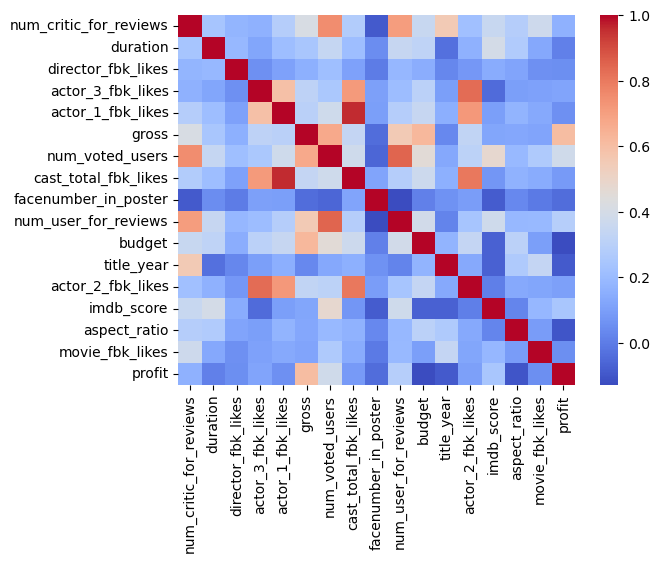

In [25]:
df_num = df.select_dtypes(include=[np.number])

corr = df_num.corr(method="spearman")
cols = df_num.columns

col1 = "gross"
for col2 in cols:
    correlation = corr[col1][col2]
    if np.abs(correlation) < 0.3:
        print(f"Negligible correlation: {col1} and {col2}")
    if 0.3 <= np.abs(correlation) < 0.5:
        print(f"Low correlation: {col1} and {col2}")
    if 0.5 <= np.abs(correlation) < 0.7:
        print(f"Moderate correlation: {col1} and {col2}")
    if 0.7 <= np.abs(correlation) < 0.9:
        print(f"High correlation: {col1} and {col2}")
    if 0.9 <= np.abs(correlation):
        print(f"Very high correlation: {col1} and {col2}")


sns.heatmap(data=corr, cmap="coolwarm")
            


Grouping based on the genre and taking the mean and filtering it based on the profit, i.e profit>0 and budget <= 1.5 million
To get the top genre

In [8]:
#Taking all the low and moderate correalted value
genreseries=df.groupby('genres')[["profit","num_critic_for_reviews","num_voted_users","cast_total_fbk_likes","num_user_for_reviews","budget","gross"]].mean()

#set the max budget
max_budget = 1500000

top_rated_genre = genreseries[genreseries['profit']>0]
Top_budget_genres = top_rated_genre[top_rated_genre['budget']<=max_budget]
Top_budget_genres = Top_budget_genres.sort_values('profit', ascending=False)
#print the genres for inspection

Top_budget_genres


,profit,num_critic_for_reviews,num_voted_users,cast_total_fbk_likes,num_user_for_reviews,budget,gross
genres,,,,,,,
Adventure|Family|Romance,39052600.0,5.0,3411.0,1090.0,36.0,500000.0,39552600.0
Adventure|Biography|Drama|Horror|Thriller,30000882.0,235.0,42256.0,67.0,916.0,500000.0,30500882.0
Documentary|History|Music,12700000.0,53.0,12631.0,778.0,63.0,600000.0,13300000.0
Comedy|Documentary|Drama,11464368.0,193.0,85028.0,0.0,404.0,65000.0,11529368.0
Documentary|Drama|Sport,7130611.0,53.0,18980.0,15.0,74.0,700000.0,7830611.0
Adventure|Horror|Sci-Fi,4790000.0,67.0,4812.0,205.0,88.0,210000.0,5000000.0
Action|Adventure|Animation|Comedy|Fantasy|Sci-Fi,4768918.0,82.0,12160.0,3071.0,73.0,750000.0,5518918.0
Biography|Crime|Documentary|History|Thriller,1957978.0,194.0,40481.0,68.0,134.0,1000000.0,2957978.0
Biography|Documentary|Sport,1547570.0,70.0,6790.0,194.0,80.0,500000.0,2047570.0


getting the top 7 genres

In [9]:
Top_genre=['Adventure','Family','Romance','Biography','Drama','Horror','Thriller']
Top_genre

['Adventure', 'Family', 'Romance', 'Biography', 'Drama', 'Horror', 'Thriller']

Plotting the box plots to check of correlated column for any outliers

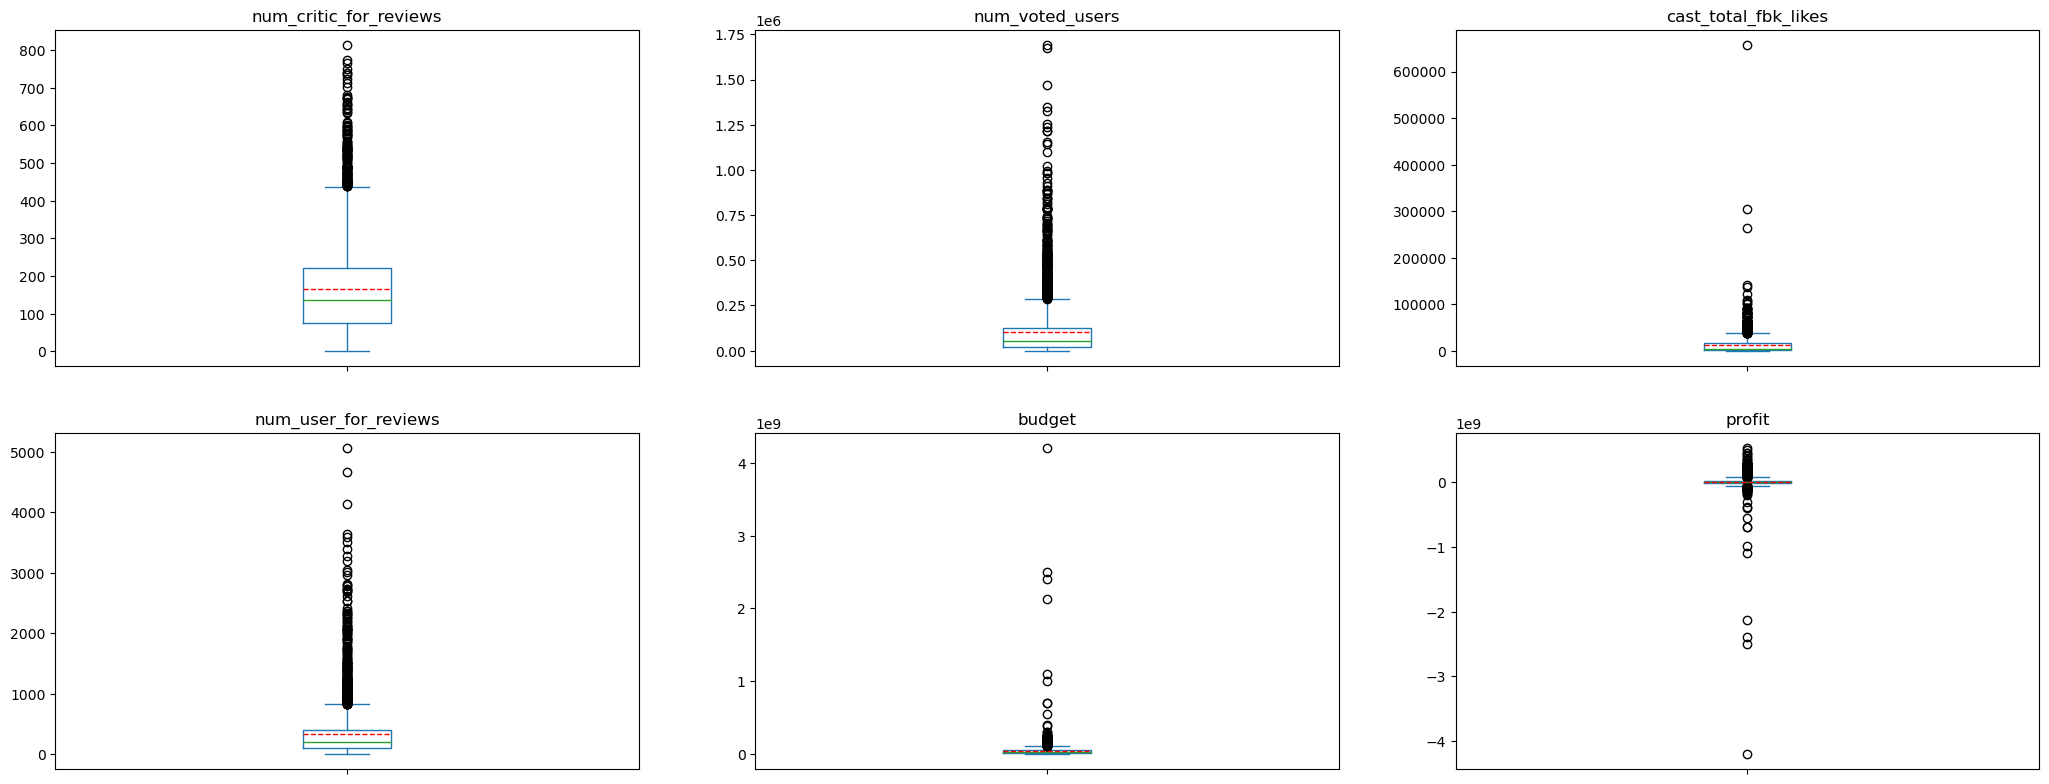

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3)

df_cols = ["num_critic_for_reviews","num_voted_users","cast_total_fbk_likes","num_user_for_reviews","budget","profit"]

for col, ax in zip(df_cols,axes.flat):
    df.plot(kind="box",ax=ax,y=col,meanline=True,showmeans=True,meanprops={"color":"r"})
    ax.set_xticklabels([""])
    ax.set_title(col)

fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2)

Plotting KDE plots for getting density, mean and median

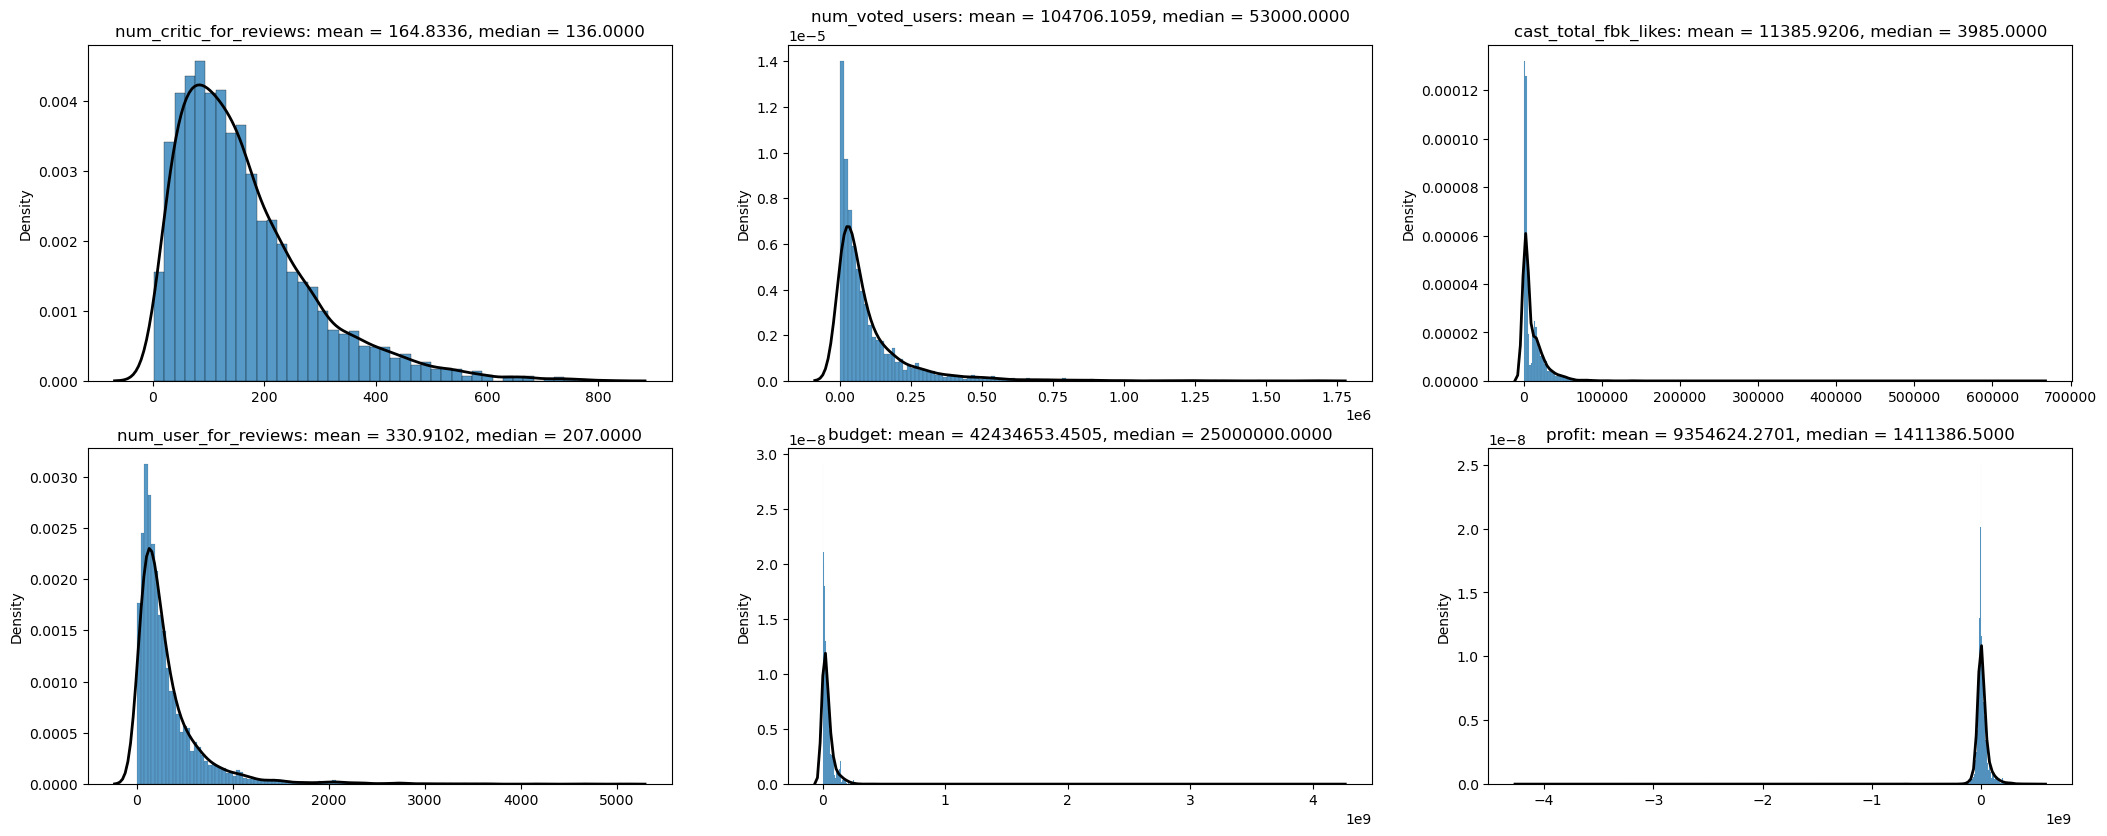

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3)

for col, ax in zip(df_cols,axes.flat):
    sns.histplot(data=df,x=col,ax=ax, stat="density")
    
    sns.kdeplot(data=df,x=col,ax=ax,color="k", linewidth=2)
    mean = df[col].mean() 
    median = df[col].median()
    ax.set_title(f"{col}: mean = {mean:.4f}, median = {median:.4f}")
    ax.set_xlabel("")
    
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2)

"num_critic_for_reviews","num_voted_users","num_user_for_reviews" looks gaussian. So let us see how the tails and modes are seen when stratifying by genre.

Plotting KDE and Hist plot for checking.

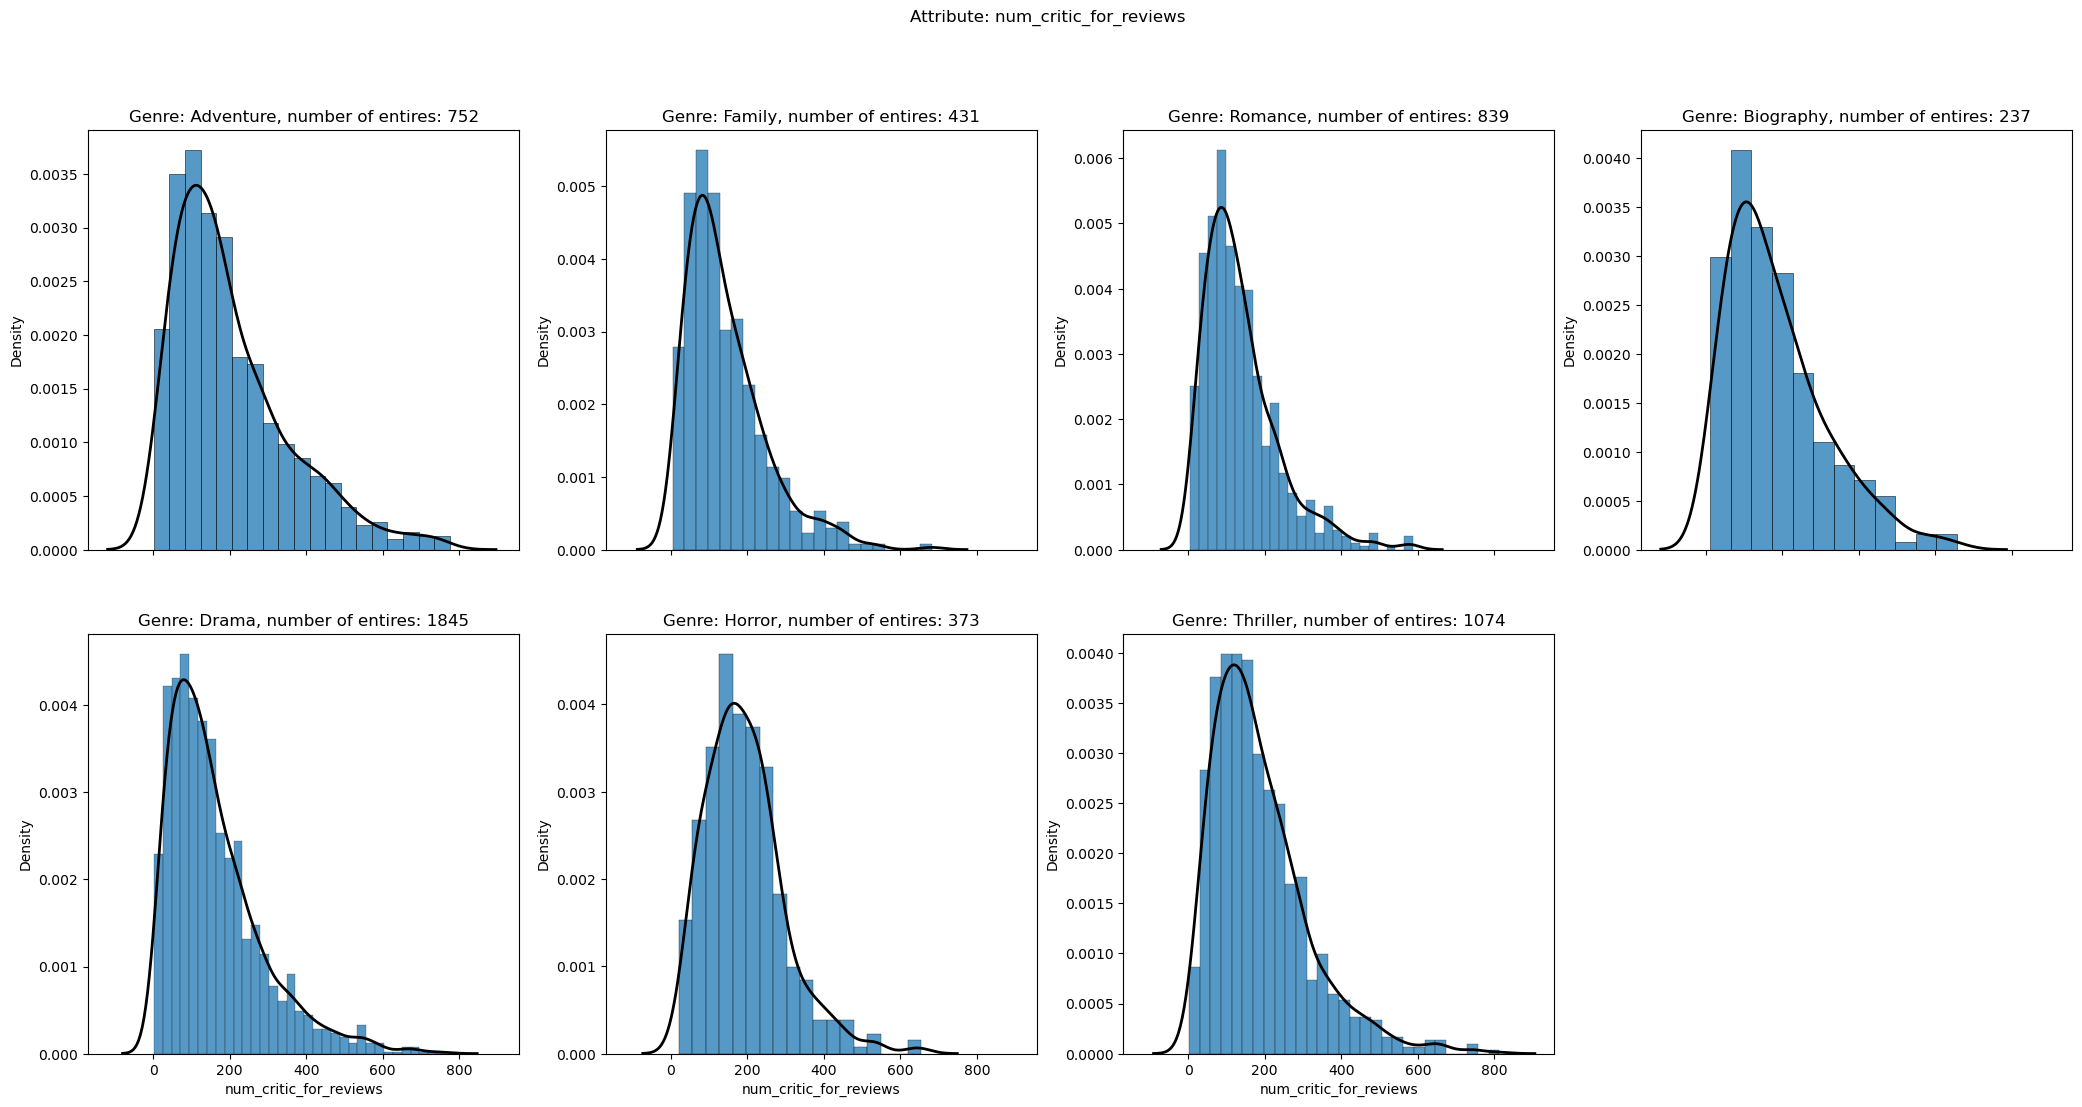

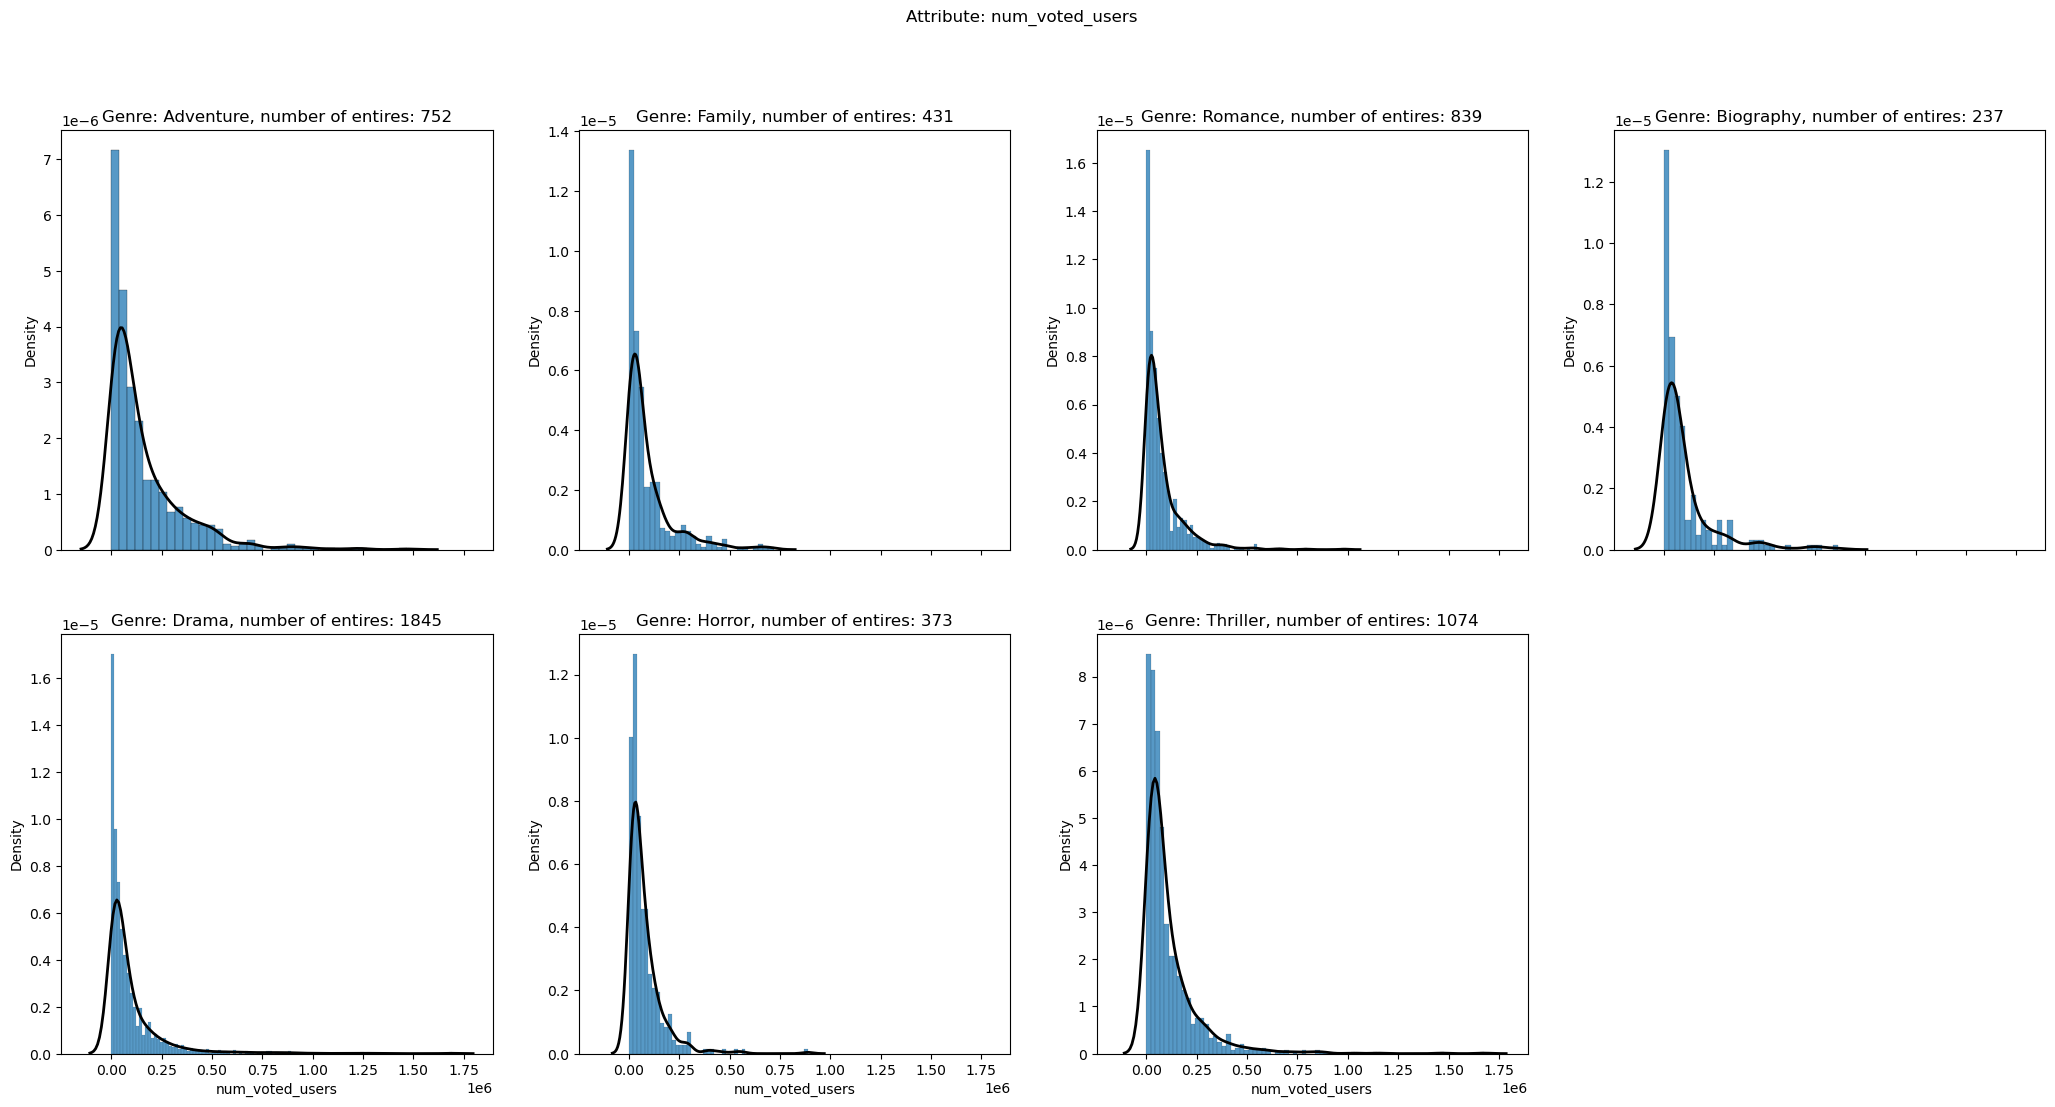

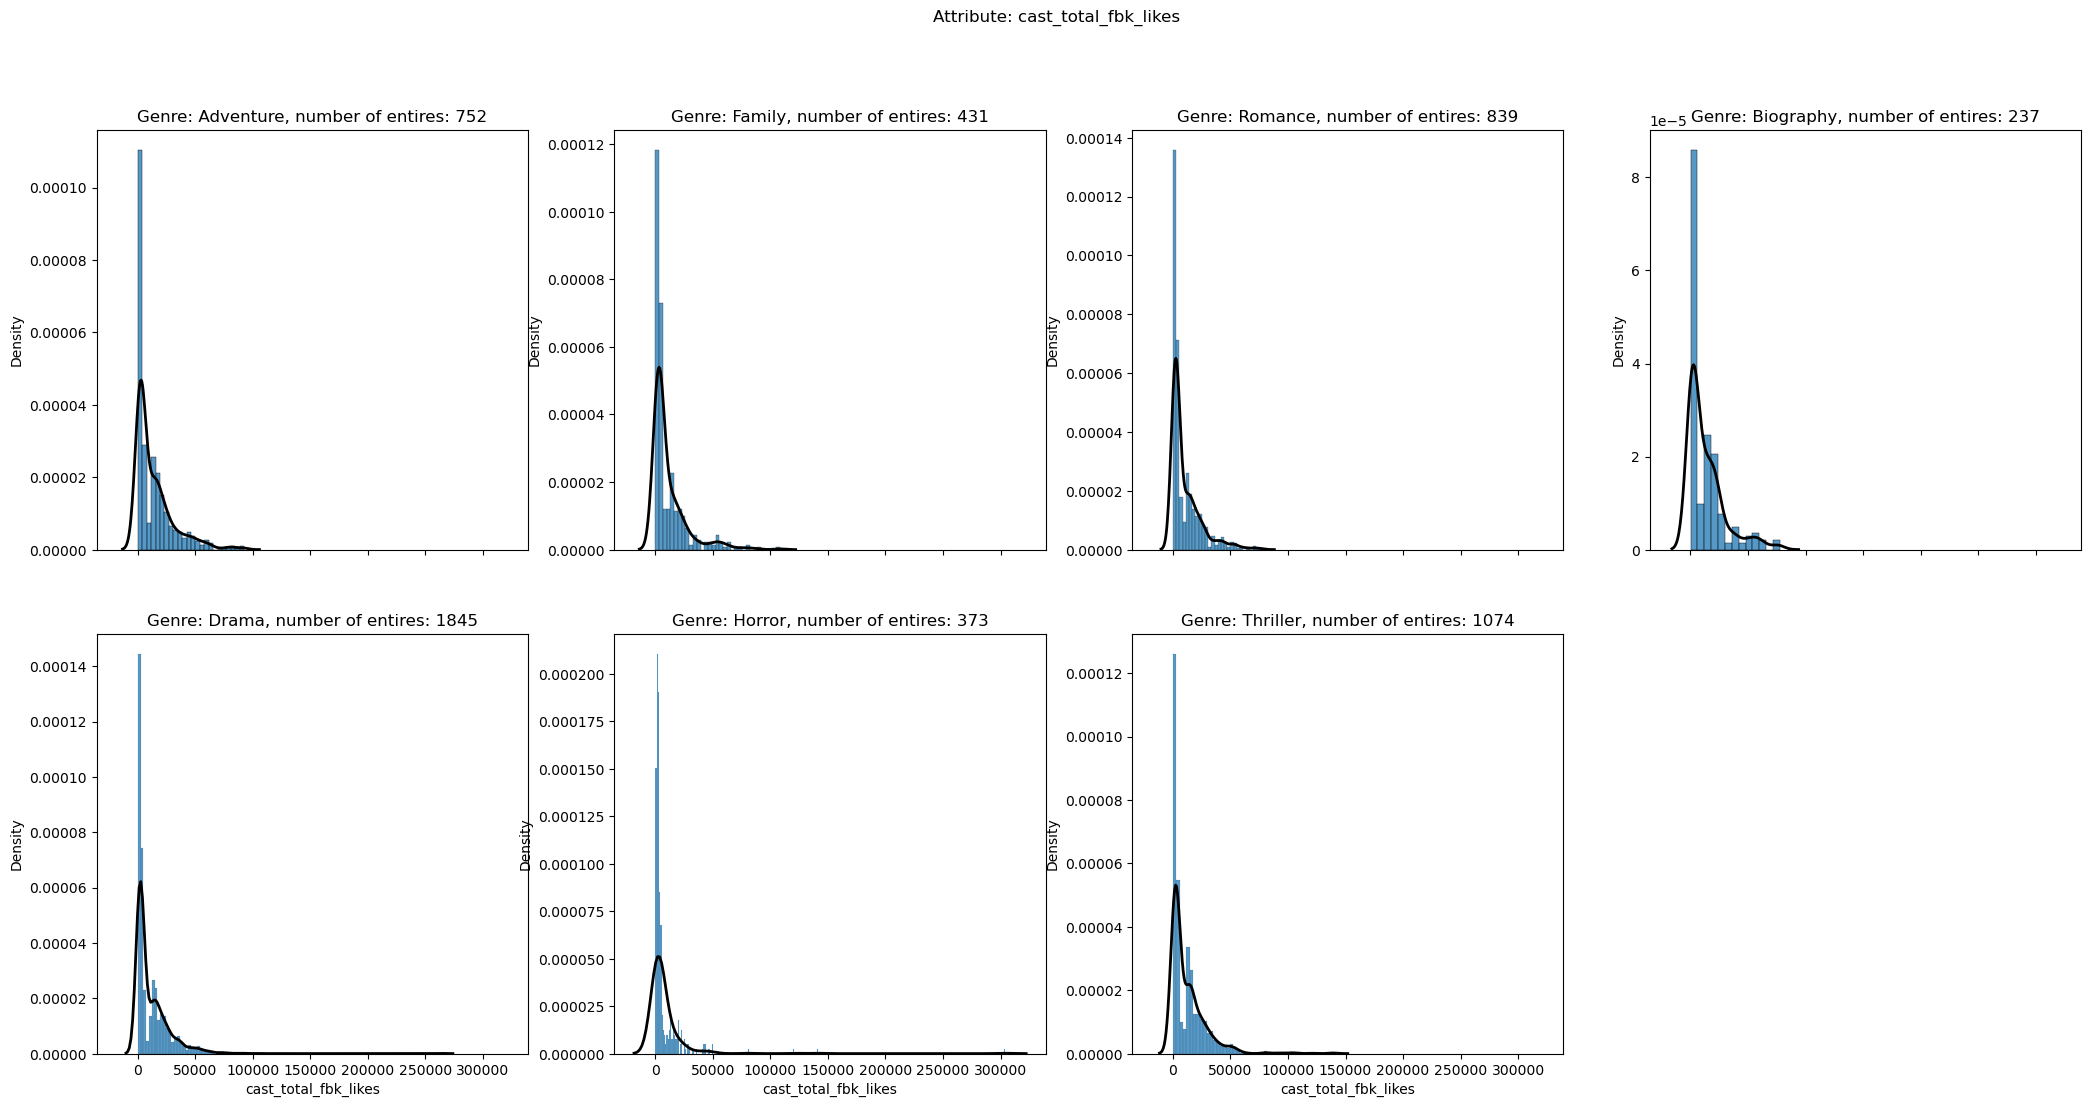

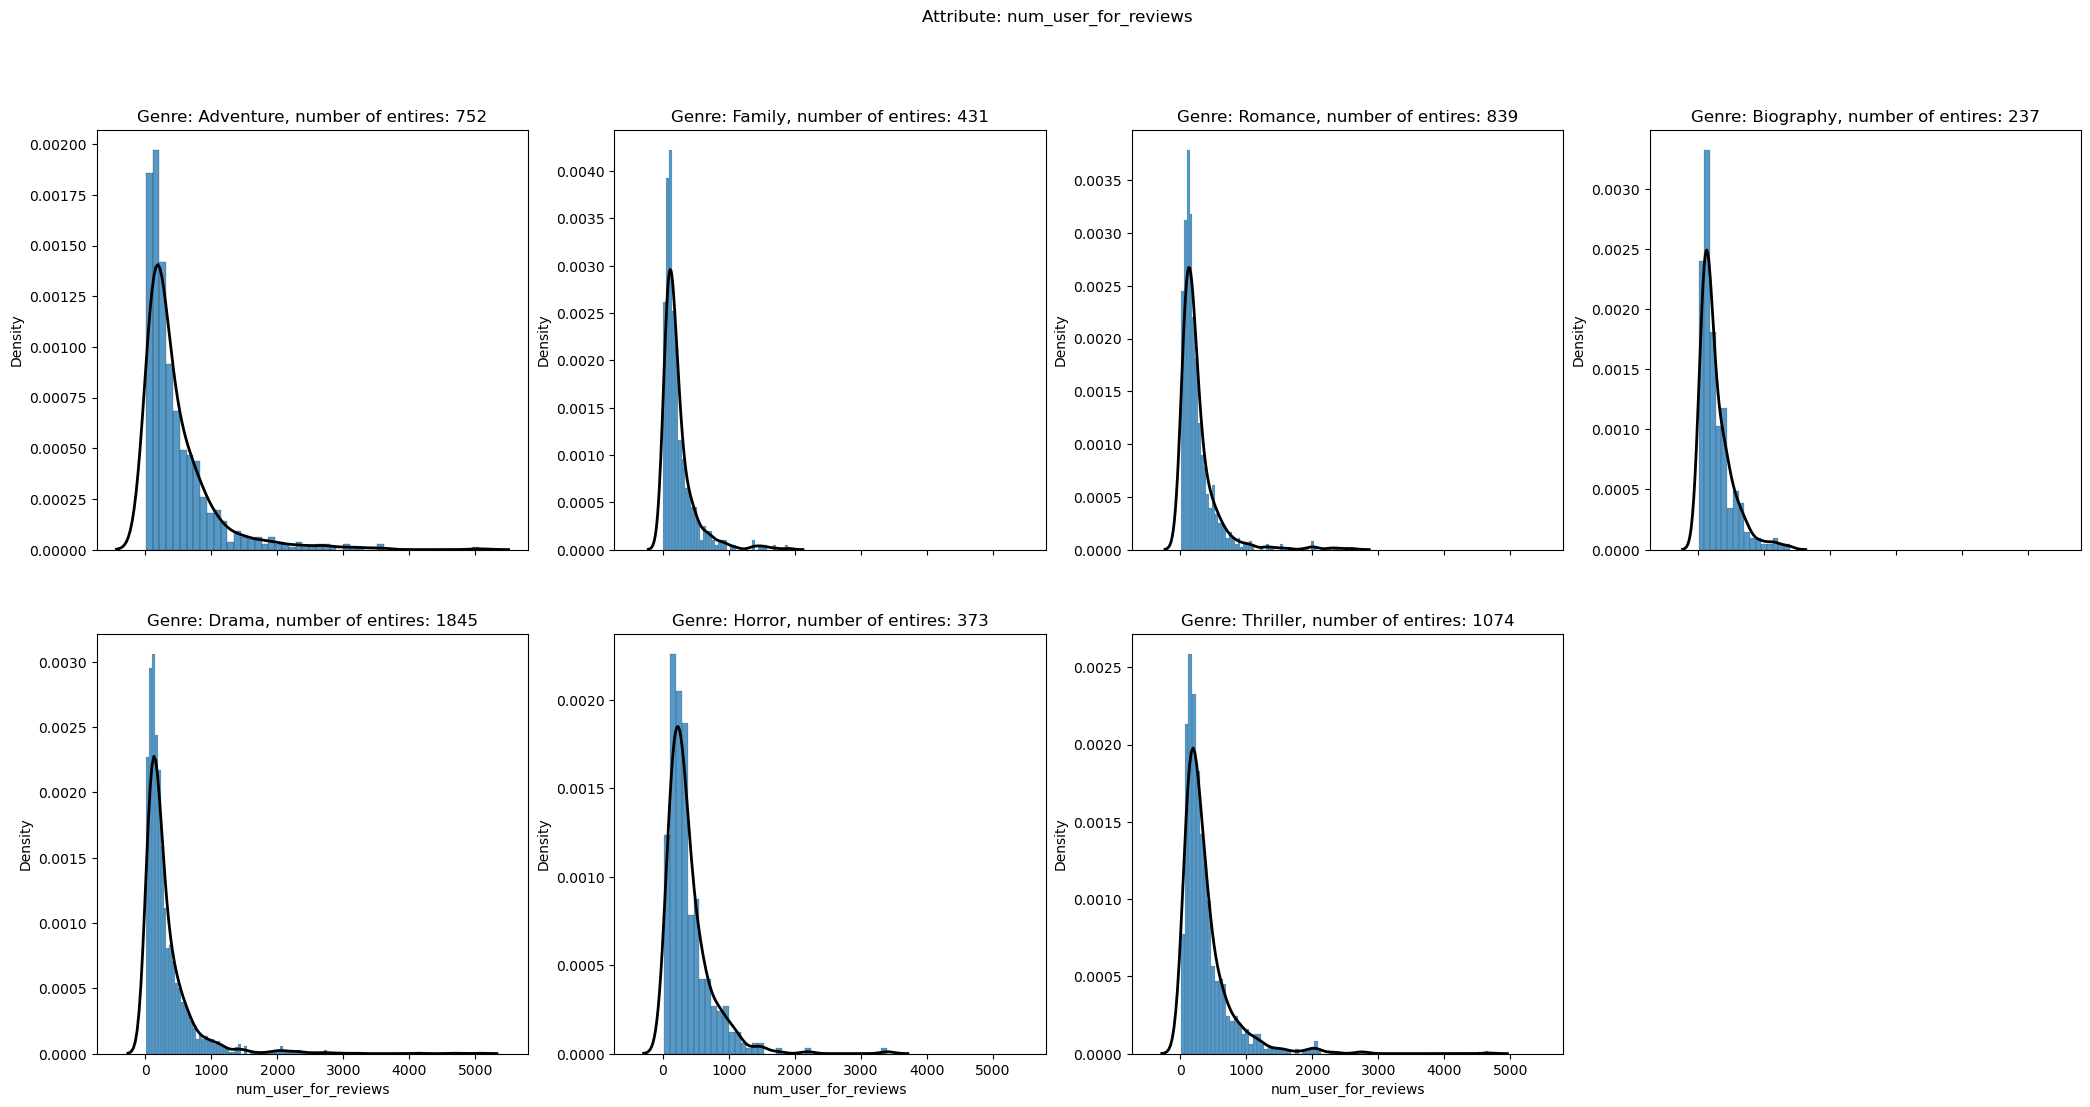

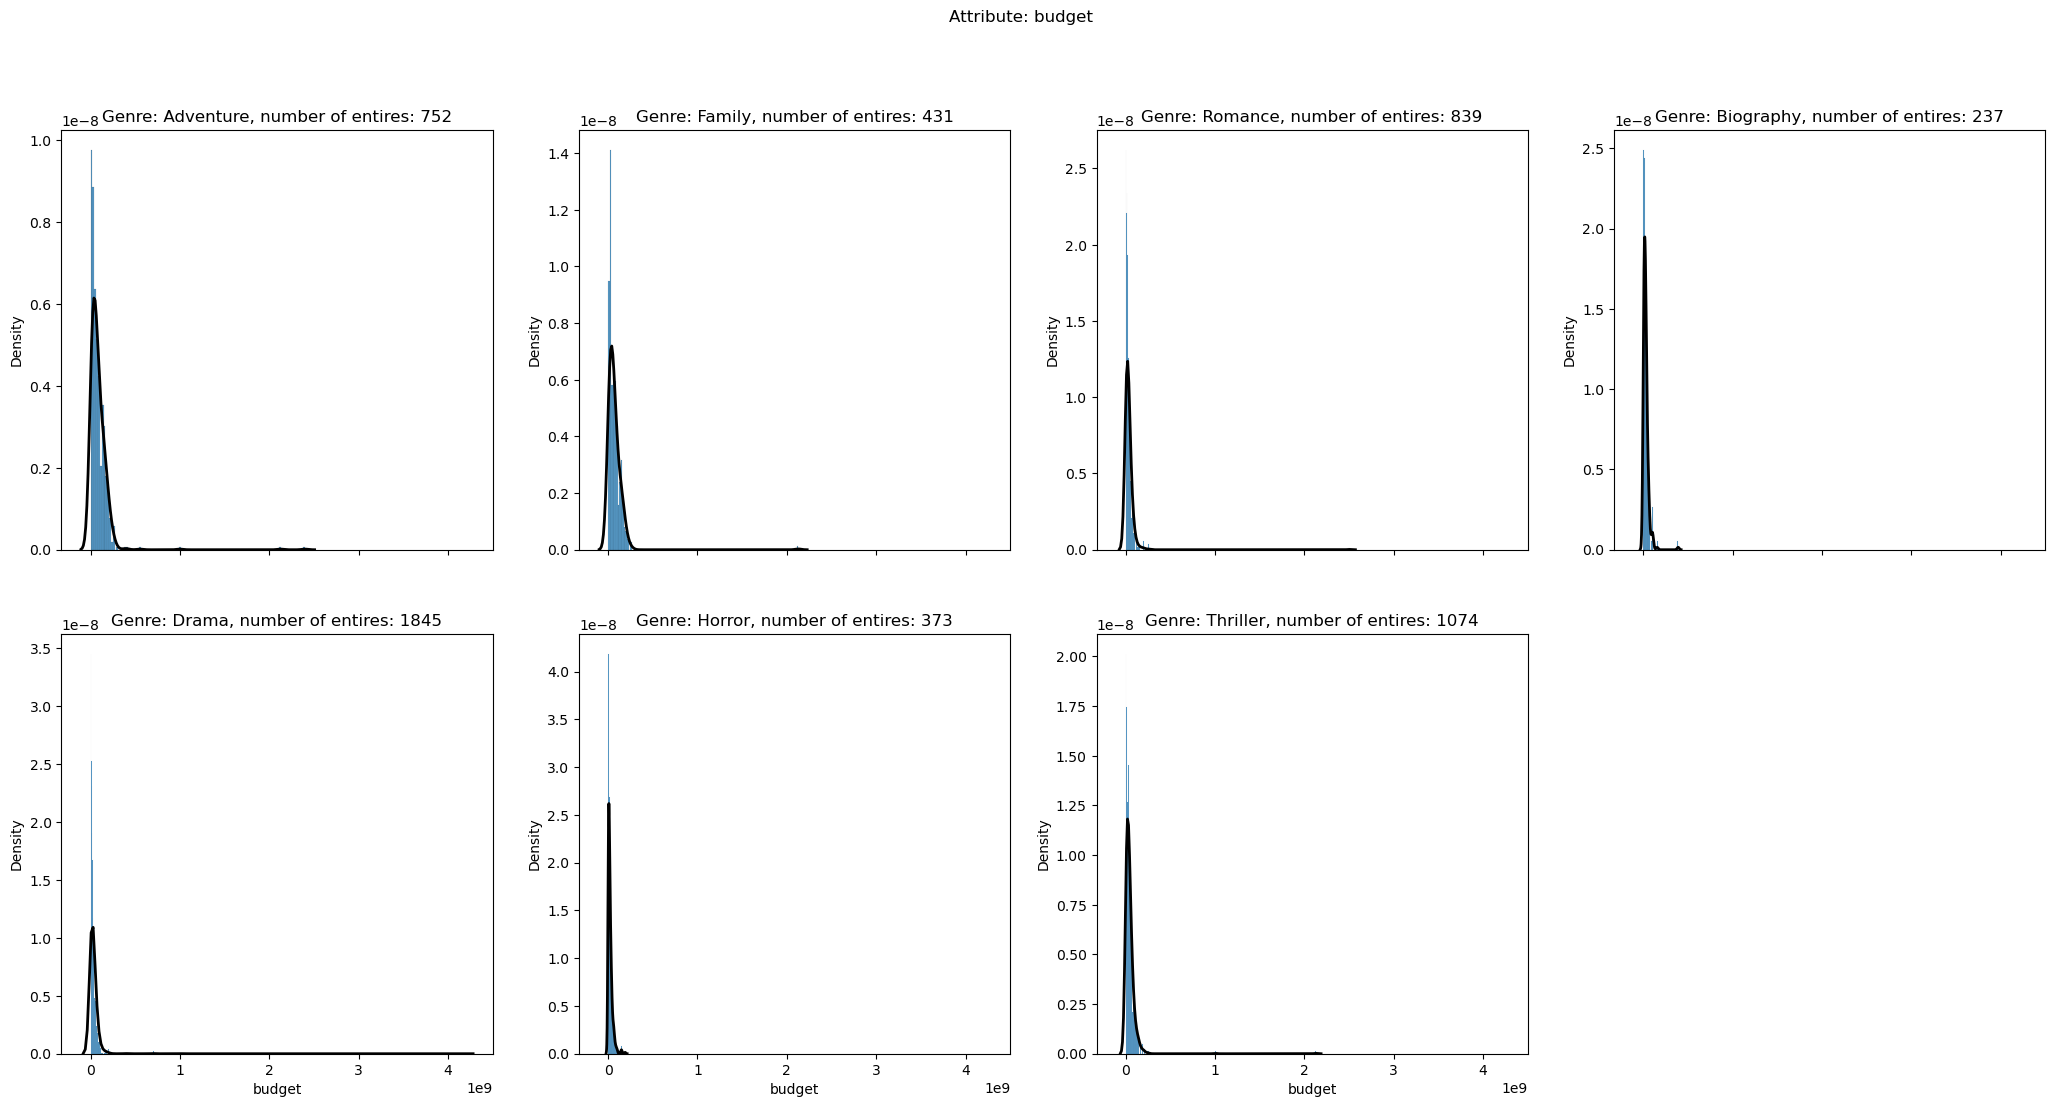

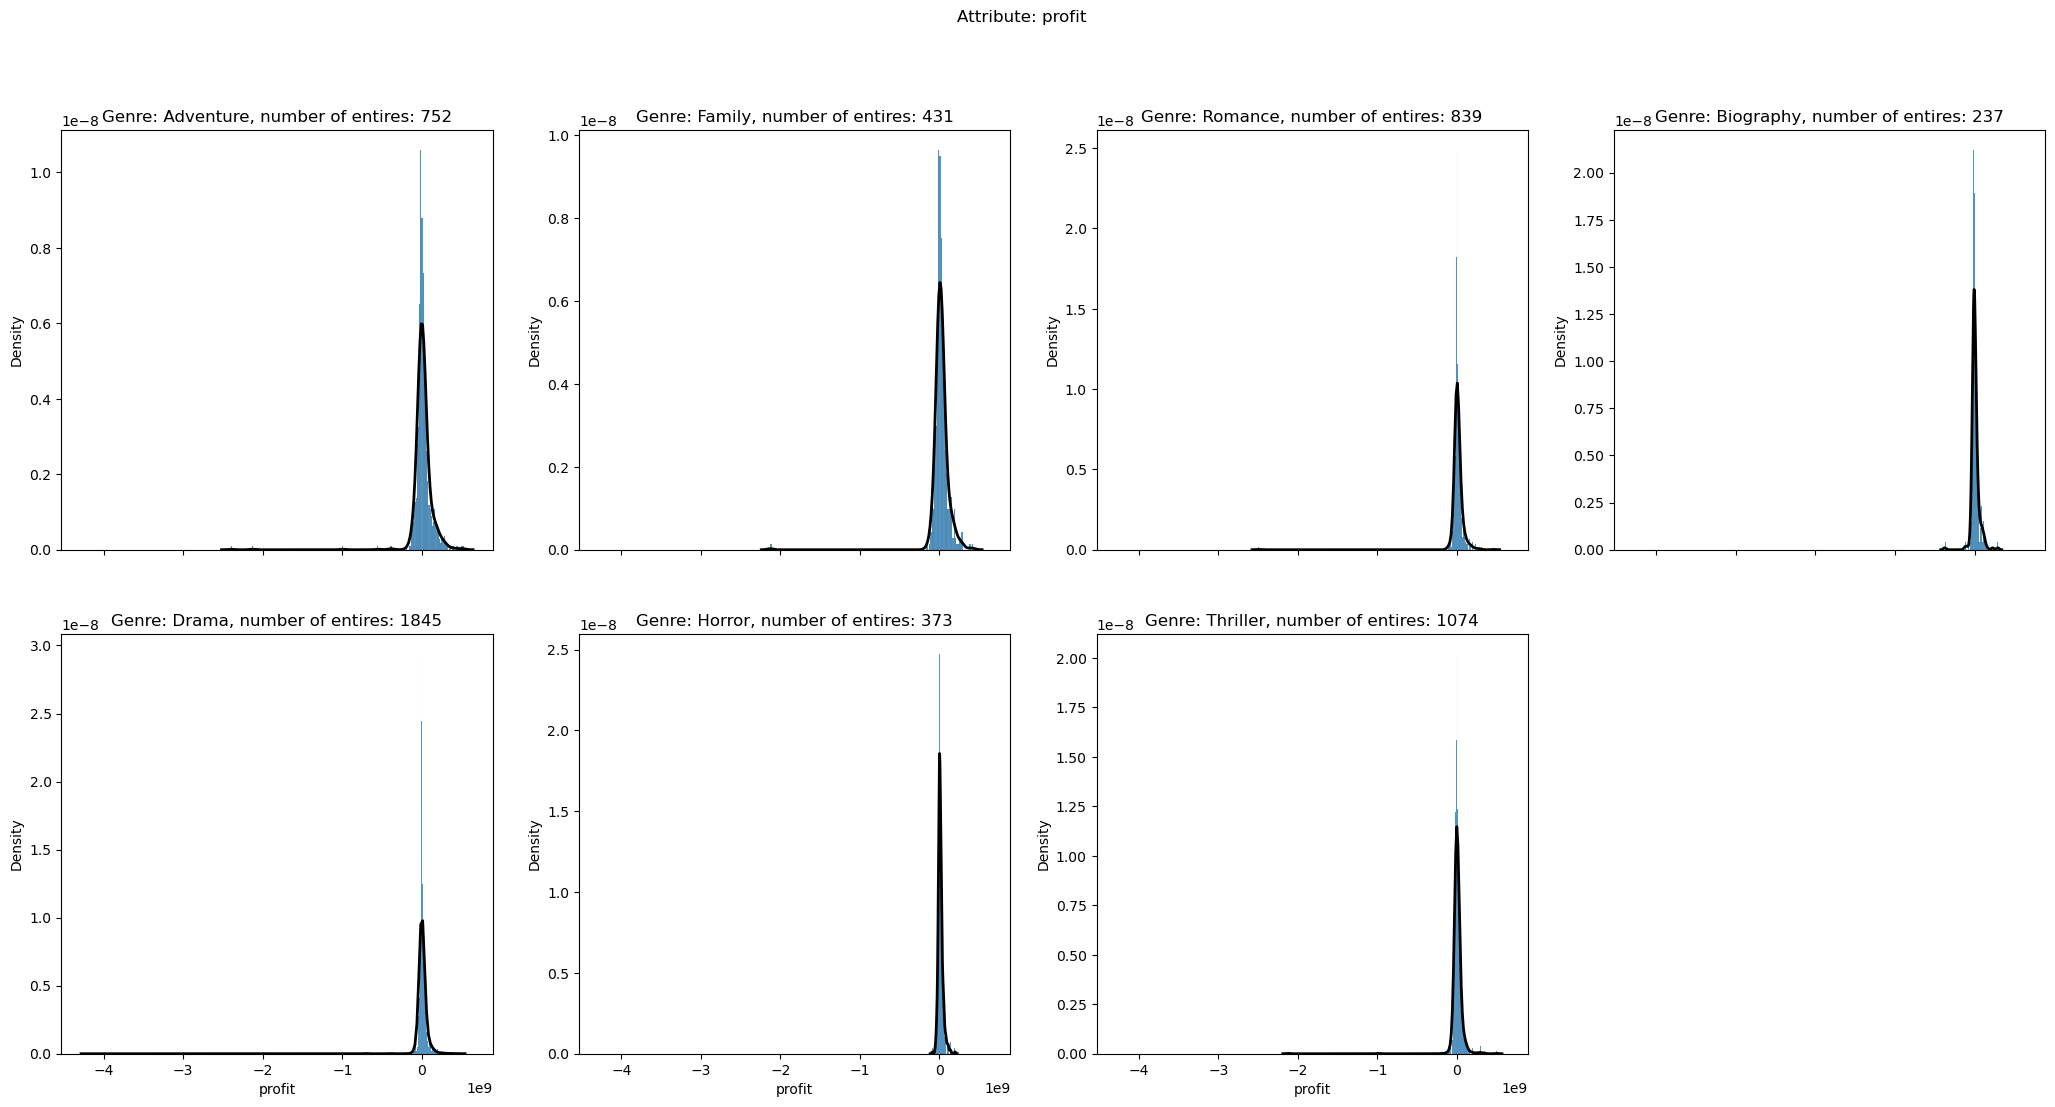

In [11]:
for col in df_cols:
    col_series = df[[col,"genres"]]
    
    fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True)
    for q,ax in zip(Top_genre,axes.flatten()):
        
        q_series = col_series[col_series["genres"].str.contains(q)][col]

        sns.histplot(data=q_series,ax=ax, stat="density")
        sns.kdeplot(data=q_series,ax=ax,color="k", linewidth=2)
        
        ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}")
        
    fig.suptitle(f"Attribute: {col}")
    fig.delaxes(axes[1][3])    
    fig.set_figwidth(fig.get_figwidth() * 4)
    fig.set_figheight(fig.get_figheight() * 2.5)

num_critic_for_reviews, num_voted_users,cast_total_fbk_likes looks Gaussian but it has few outliers

num_user_for_reviews,budget,profit doesn't look Gaussian at all

I am going to check the distributions first to see if any are Gaussian. I will do a Lilliefors test and P-P plots.

## num_critic_for_reviews

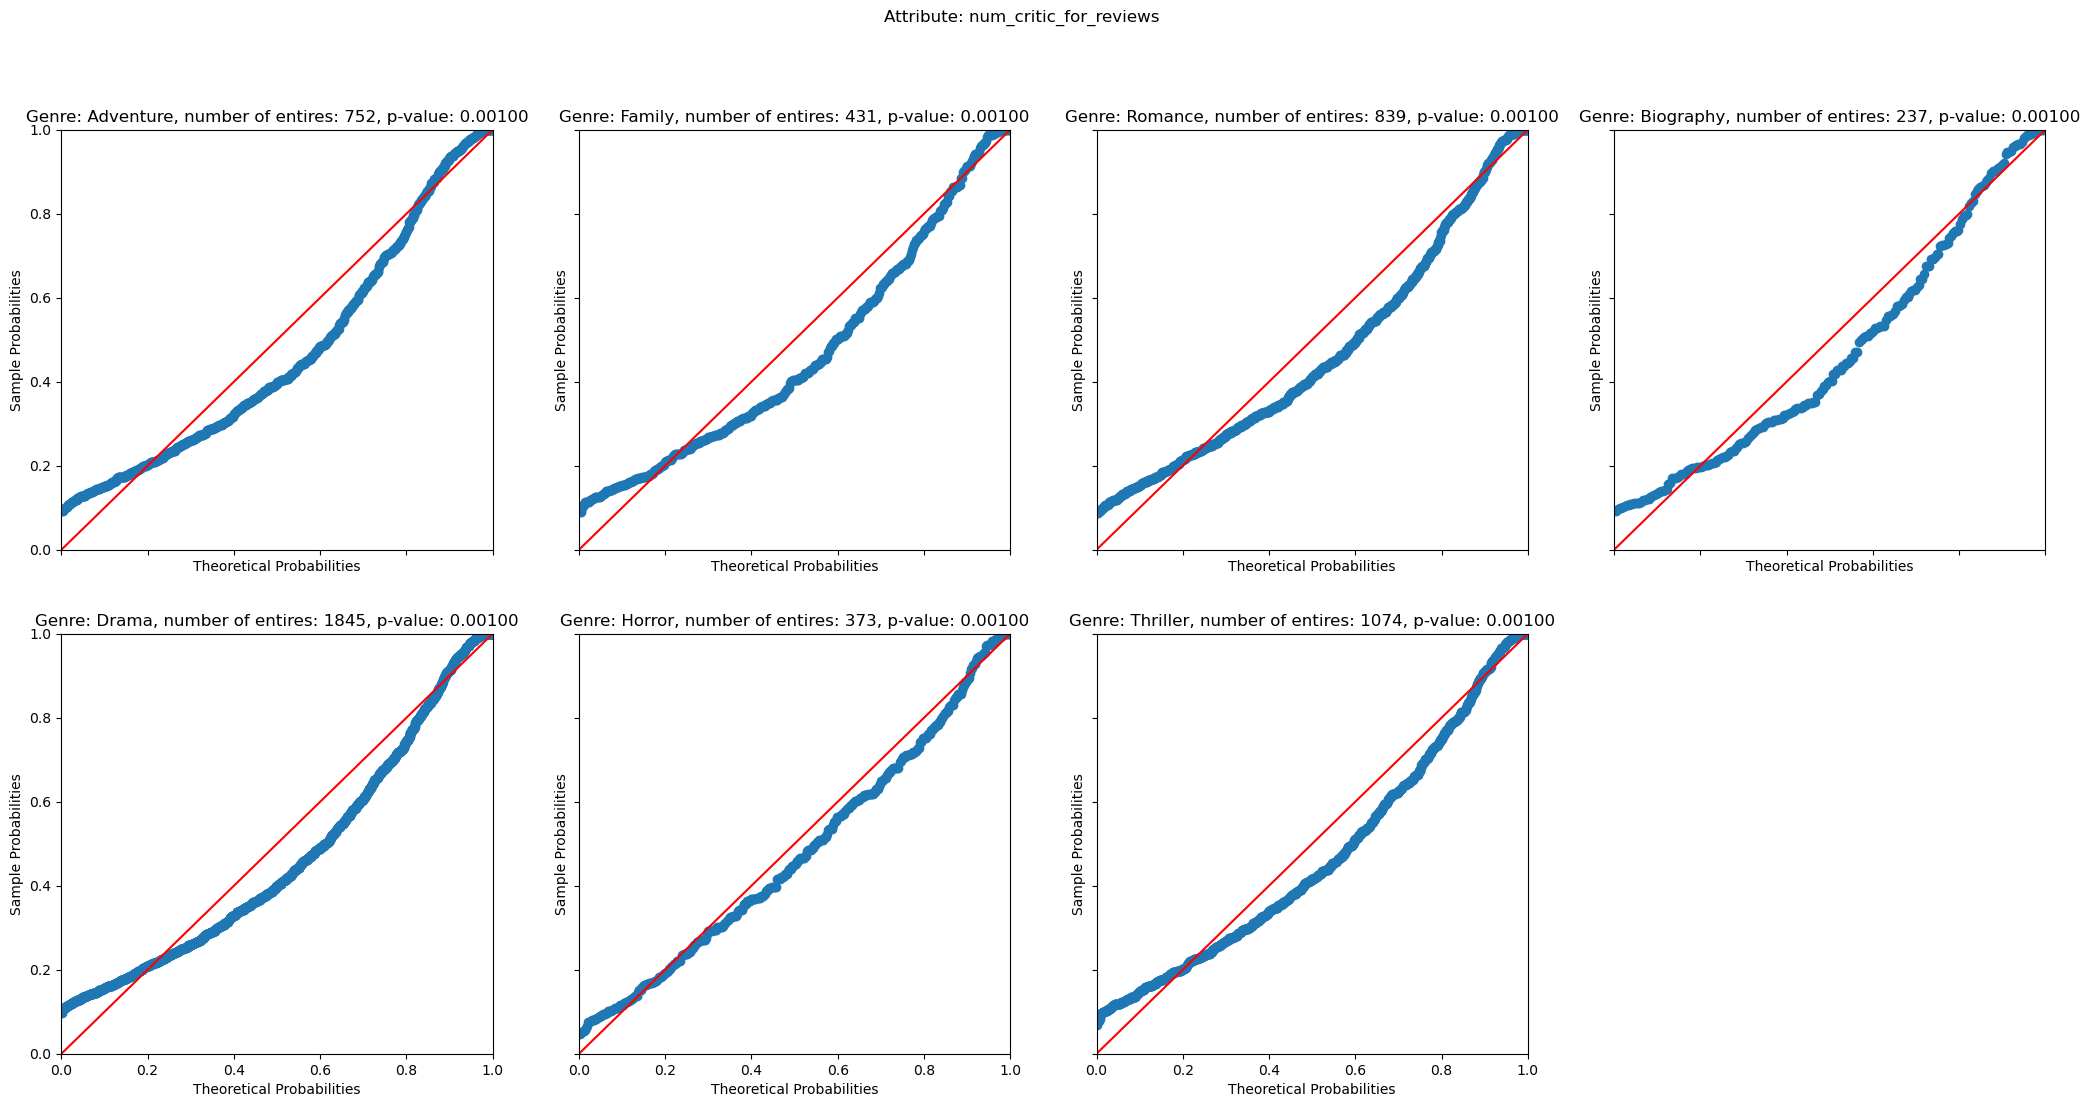

In [12]:
col = "num_critic_for_reviews"
col_series = df[[col,"genres"]]

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    _, p_value = lilliefors(q_series,dist="norm")

    pp_x = sm.ProbPlot(q_series, dist=norm, fit=True)
    pp_x.ppplot(line="45",ax=ax)
    
    ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}, p-value: {p_value:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

The P-P plot of genre "Horror" looks gaussian, lets plot ecdf to check

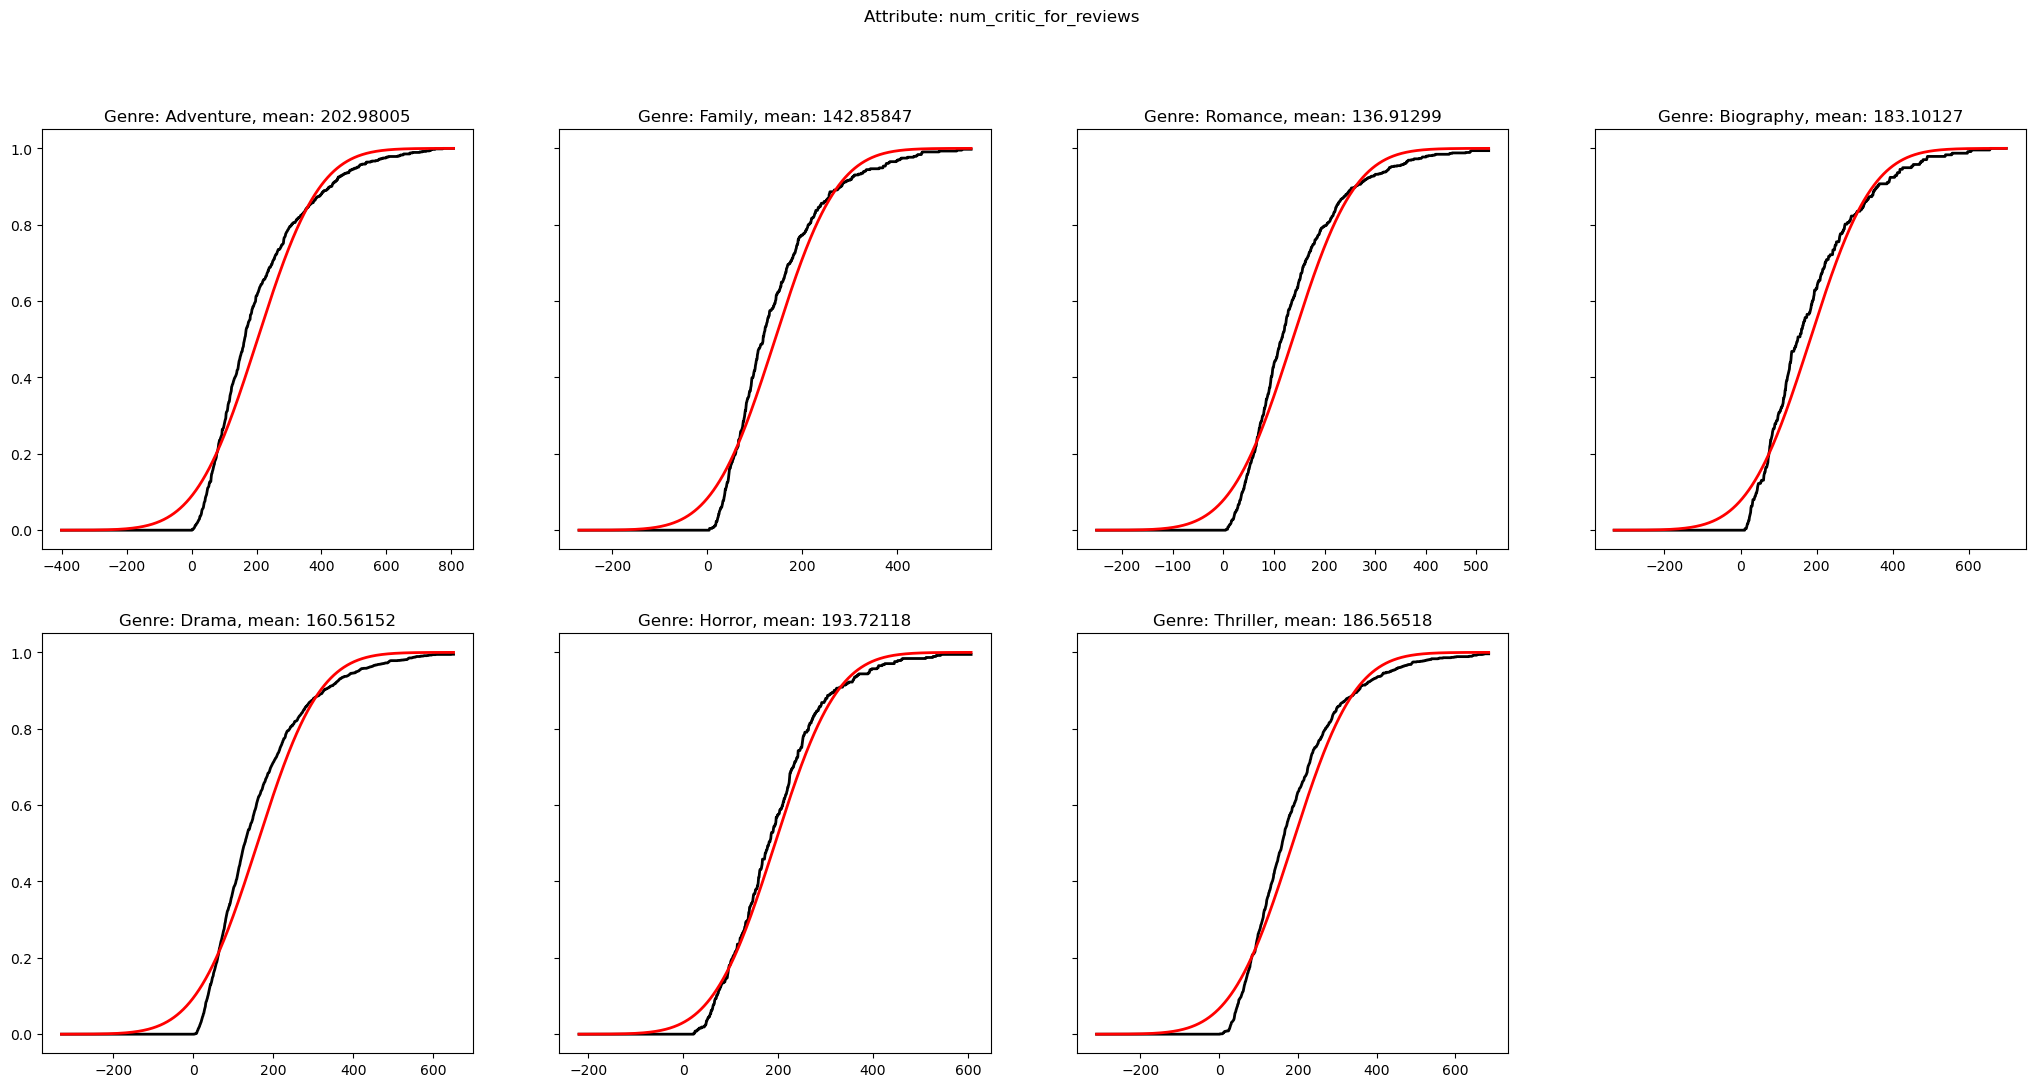

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    ecdf = ECDF(q_series)
    
    mean = q_series.mean()
    std = q_series.std(ddof=1)
    
    xax = np.linspace(mean - 4*std,mean + 4*std,1001)
    
    ax.plot(xax,ecdf(xax),c="k",lw=2)
    ax.plot(xax,norm(loc=mean,scale=std).cdf(xax),c="r",lw=2)
    
    ax.set_title(f"Genre: {q}, mean: {mean:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])   
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

Genre "Horror" looks reasonably Gaussian.
If we can show that the means between each genre are different, then we can make some actionable advice to decrease the levels of chloride in the wine production. Since we can't make a Gaussian assumption, we will need to use Bootstrapping!

In [14]:
def bootstrap_diff_means(data_1,data_2,num_bootstraps=10000):
    m_1 = np.mean(data_1)
    m_2 = np.mean(data_2)
    v_1 = np.var(data_1, ddof=1)
    v_2 = np.var(data_2, ddof=1)
    n_1 = len(data_1)
    n_2 = len(data_2)
    se = np.sqrt(v_1/n_1 + v_2/n_2)
    t_stat = (m_1 - m_2)/se

    comb_m = (np.sum(data_1) + np.sum(data_2))/(n_1 + n_2)

    adj_col1 = data_1 - m_1 + comb_m
    adj_col2 = data_2 - m_2 + comb_m

    count = 0
    for _ in range(num_bootstraps):
        bs_1 = np.array([adj_col1[i] for i in np.random.randint(0,n_1,size=n_1)])
        bs_2 = np.array([adj_col2[i] for i in np.random.randint(0,n_2,size=n_2)]) 
        
        bs_m_1 = np.mean(bs_1)
        bs_m_2 = np.mean(bs_2)
        bs_v_1 = np.var(bs_1,ddof=1)
        bs_v_2 = np.var(bs_2,ddof=1)
        bs_se = np.sqrt(bs_v_1/n_1 + bs_v_2/n_2)
        
        bs_t_stat = (bs_m_1 - bs_m_2)/bs_se
        
        if np.abs(bs_t_stat) >= np.abs(t_stat):
            count += 1 

    return m_1 - m_2, t_stat, (count+1)/(num_bootstraps+1)


In [15]:
for q1,q2 in zip(Top_genre[:-1],Top_genre[1:]):

    data_1 = col_series[col_series["genres"].str.contains(q1)][col].to_numpy()
    data_2 = col_series[col_series["genres"].str.contains(q2)][col].to_numpy()
    
    d0 = 0 
    dbar, _, p_value = bootstrap_diff_means(data_1,data_2)
    print(f"Comparing {col} for genre {q1} and {q2}")
    print(f"There is a probability of {p_value:.4f} that the observed difference of mean being different to {dbar:.4f} given the underlying difference of means is 0")
    print("\n")

Comparing num_critic_for_reviews for genre Adventure and Family
There is a probability of 0.0001 that the observed difference of mean being different to 60.1216 given the underlying difference of means is 0


Comparing num_critic_for_reviews for genre Family and Romance
There is a probability of 0.3184 that the observed difference of mean being different to 5.9455 given the underlying difference of means is 0


Comparing num_critic_for_reviews for genre Romance and Biography
There is a probability of 0.0001 that the observed difference of mean being different to -46.1883 given the underlying difference of means is 0


Comparing num_critic_for_reviews for genre Biography and Drama
There is a probability of 0.0120 that the observed difference of mean being different to 22.5397 given the underlying difference of means is 0


Comparing num_critic_for_reviews for genre Drama and Horror
There is a probability of 0.0001 that the observed difference of mean being different to -33.1597 given th

So this implies that there is statistically no significant difference between num_critic_for_reviews for genres
(Family, Romance), (Biography, Drama) and (Horror, Thriller).

## num_voted_users

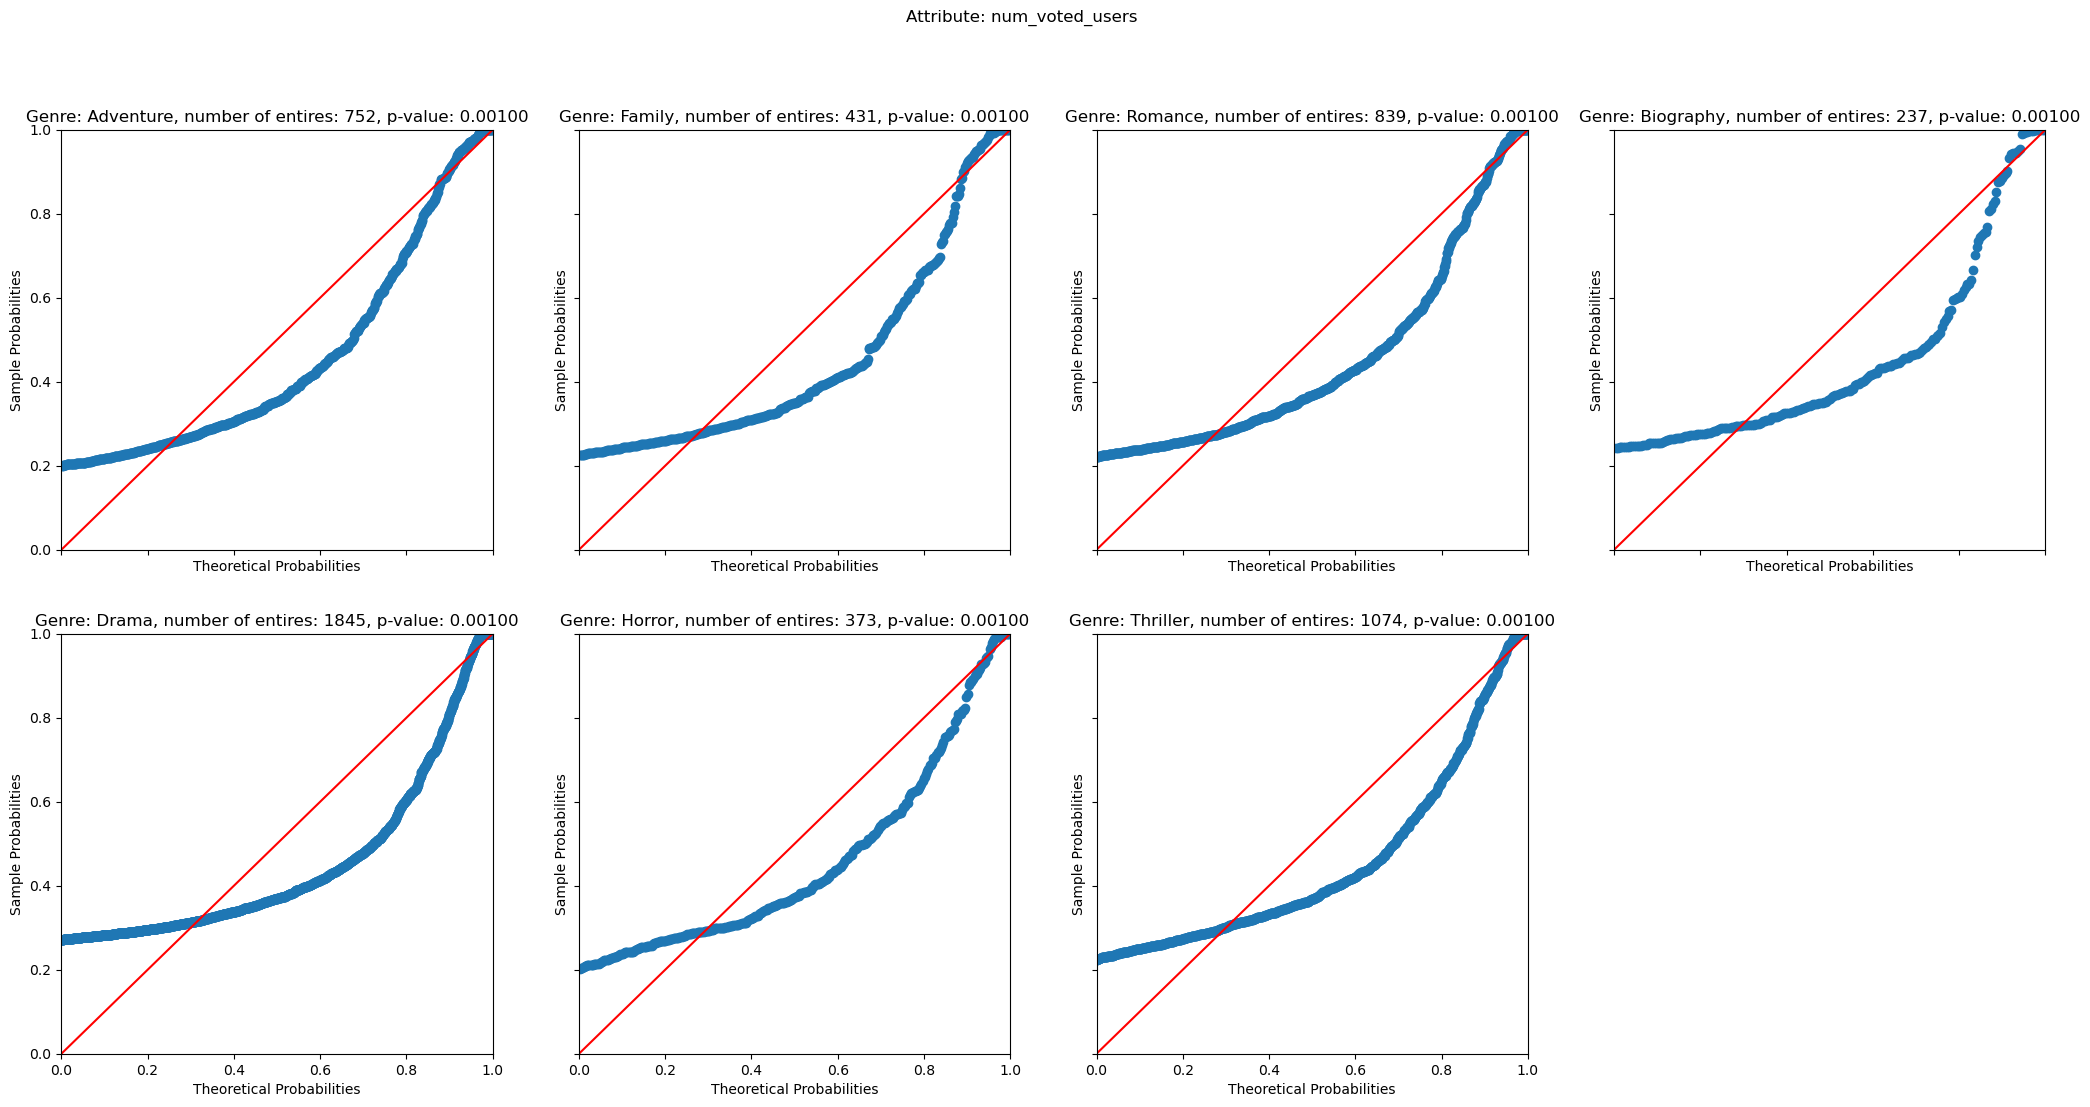

In [16]:
col = "num_voted_users"
col_series = df[[col,"genres"]]

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    _, p_value = lilliefors(q_series,dist="norm")

    pp_x = sm.ProbPlot(q_series, dist=norm, fit=True)
    pp_x.ppplot(line="45",ax=ax)
    
    ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}, p-value: {p_value:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

None of the P-P plot looks gaussian, lets plot ecdf to check

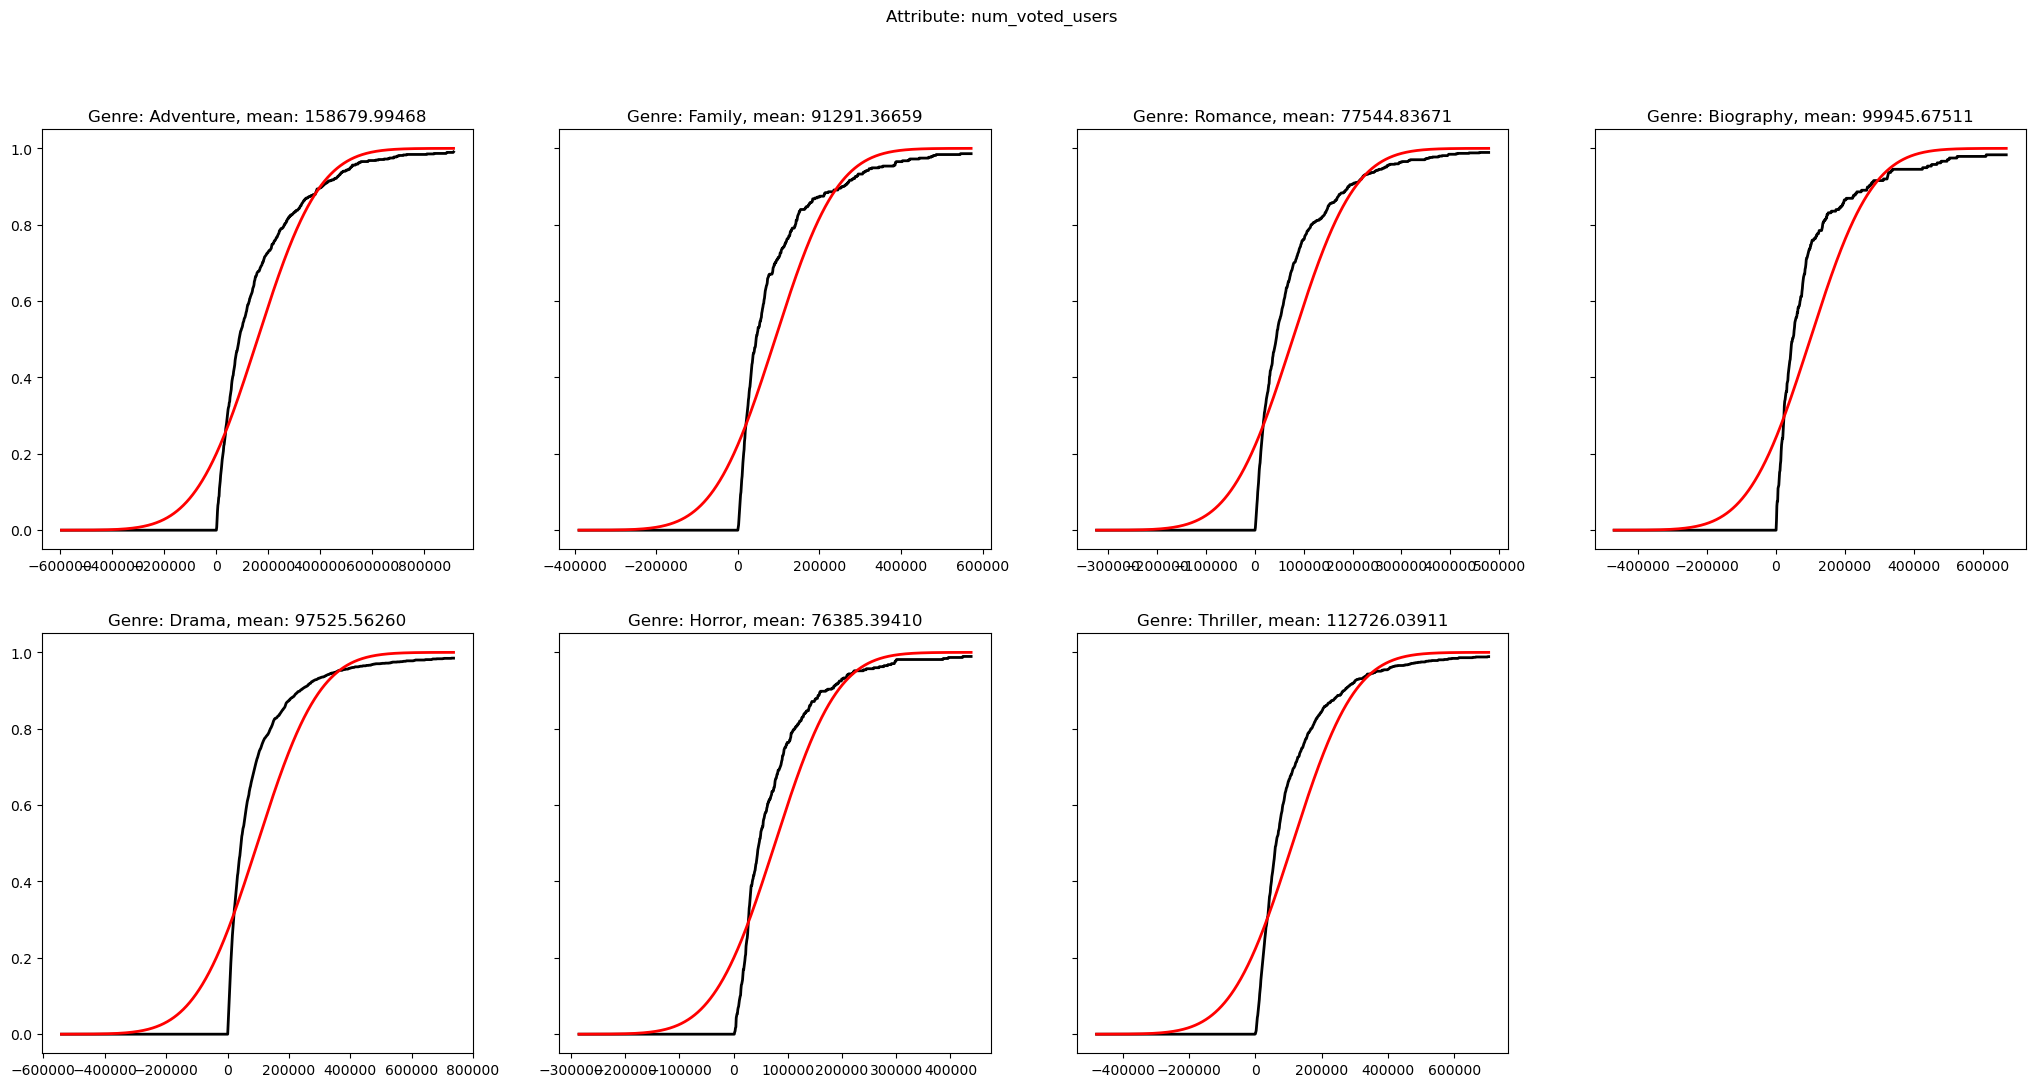

In [17]:

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    ecdf = ECDF(q_series)
    
    mean = q_series.mean()
    std = q_series.std(ddof=1)
    
    xax = np.linspace(mean - 4*std,mean + 4*std,1001)
     
    ax.plot(xax,ecdf(xax),c="k",lw=2)
    ax.plot(xax,norm(loc=mean,scale=std).cdf(xax),c="r",lw=2)
    
    ax.set_title(f"Genre: {q}, mean: {mean:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

In [18]:
for q1,q2 in zip(Top_genre[:-1],Top_genre[1:]):

    data_1 = col_series[col_series["genres"].str.contains(q1)][col].to_numpy()
    data_2 = col_series[col_series["genres"].str.contains(q2)][col].to_numpy()
    
    d0 = 0 
    dbar, _, p_value = bootstrap_diff_means(data_1,data_2)
    print(f"Comparing {col} for genre {q1} and {q2}")
    print(f"There is a probability of {p_value:.4f} that the observed difference of mean being different to {dbar:.4f} given the underlying difference of means is 0")
    print("\n")

Comparing num_voted_users for genre Adventure and Family
There is a probability of 0.0001 that the observed difference of mean being different to 67388.6281 given the underlying difference of means is 0


Comparing num_voted_users for genre Family and Romance
There is a probability of 0.0446 that the observed difference of mean being different to 13746.5299 given the underlying difference of means is 0


Comparing num_voted_users for genre Romance and Biography
There is a probability of 0.0296 that the observed difference of mean being different to -22400.8384 given the underlying difference of means is 0


Comparing num_voted_users for genre Biography and Drama
There is a probability of 0.8053 that the observed difference of mean being different to 2420.1125 given the underlying difference of means is 0


Comparing num_voted_users for genre Drama and Horror
There is a probability of 0.0005 that the observed difference of mean being different to 21140.1685 given the underlying differen

So this implies that there is statistically no significant difference between num_voted_users for genres (Adventure, Family) and (Horror, Thriller).

## cast_total_fbk_likes

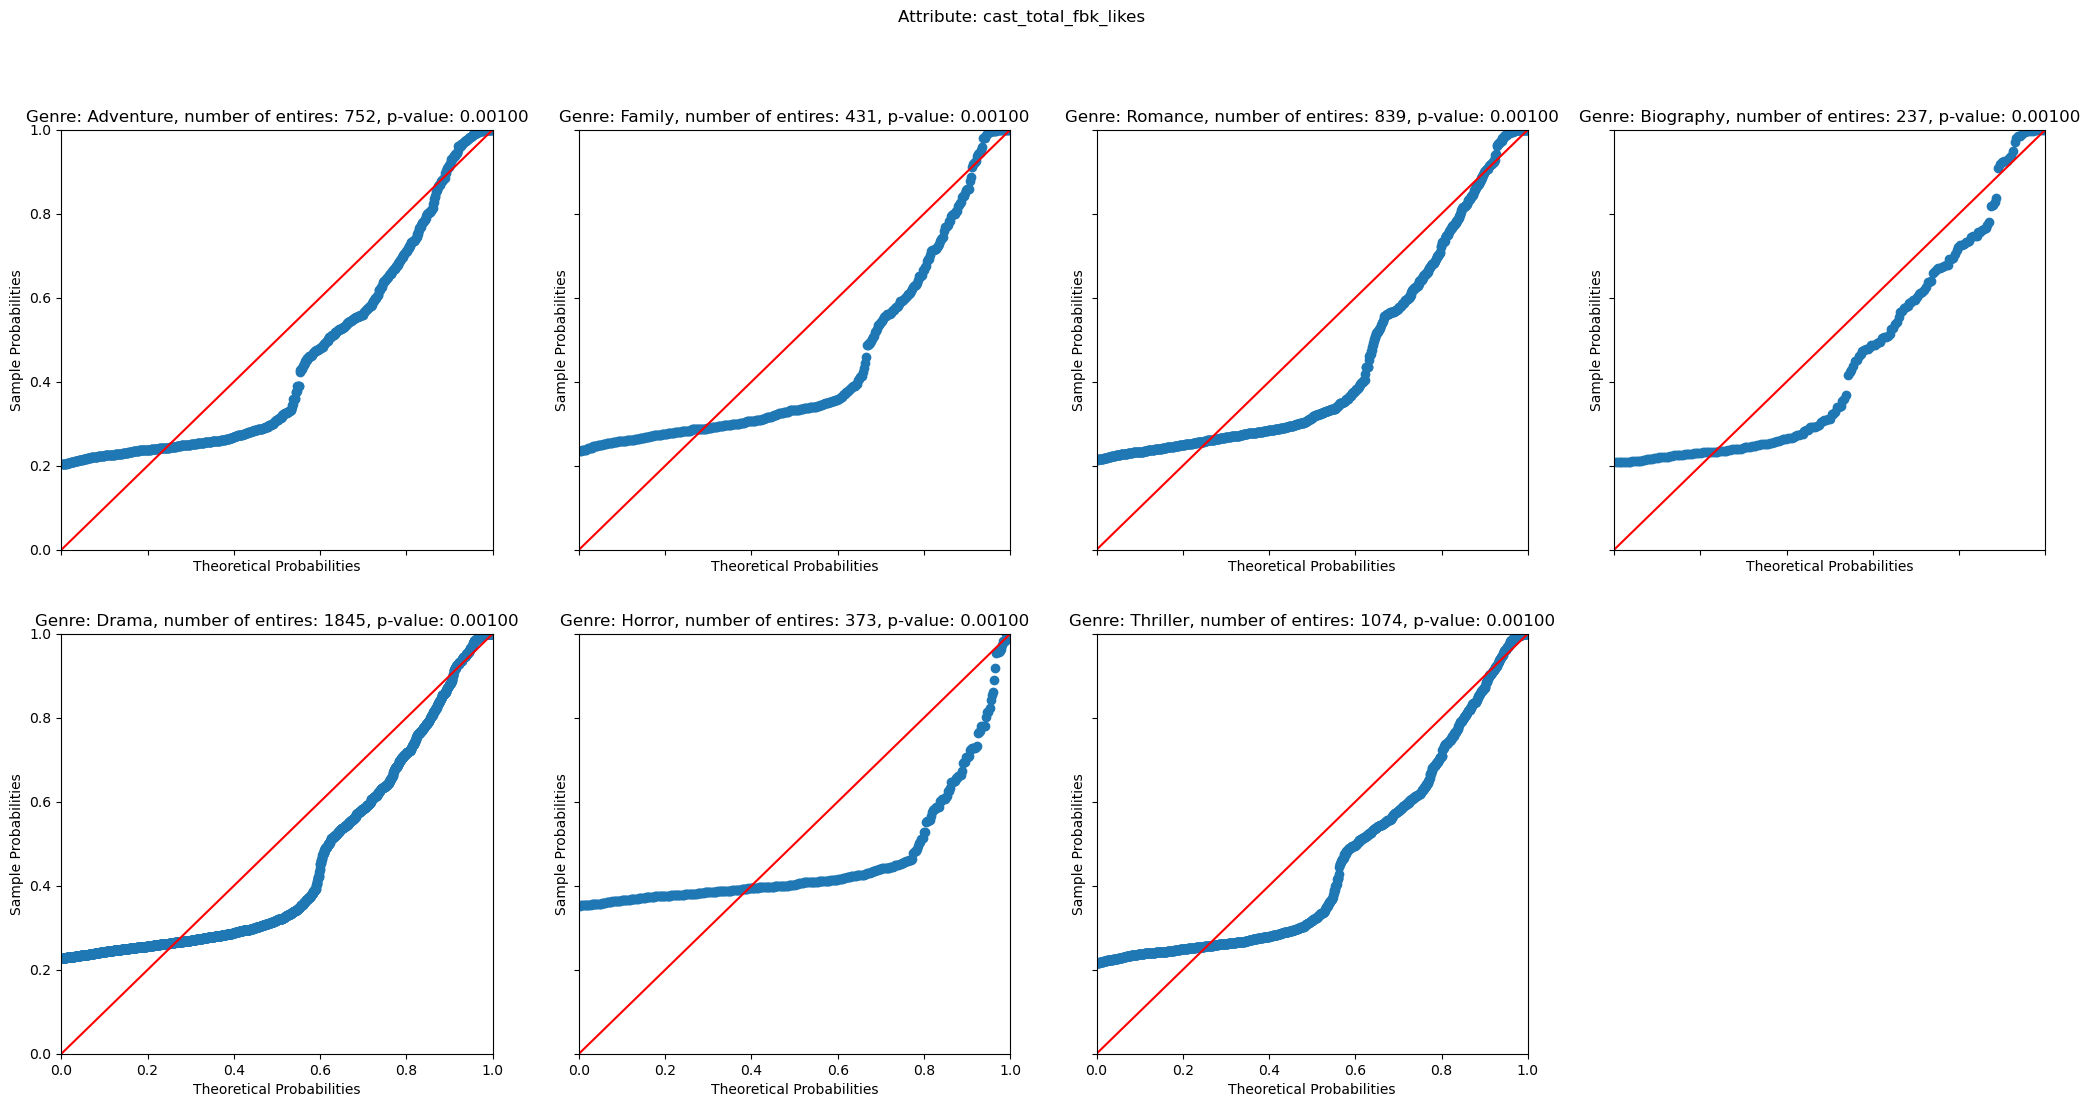

In [19]:
col = "cast_total_fbk_likes"
col_series = df[[col,"genres"]]

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    _, p_value = lilliefors(q_series,dist="norm")

    pp_x = sm.ProbPlot(q_series, dist=norm, fit=True)
    pp_x.ppplot(line="45",ax=ax)
    
    ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}, p-value: {p_value:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

None of the P-P plot looks gaussian, lets plot ecdf to check

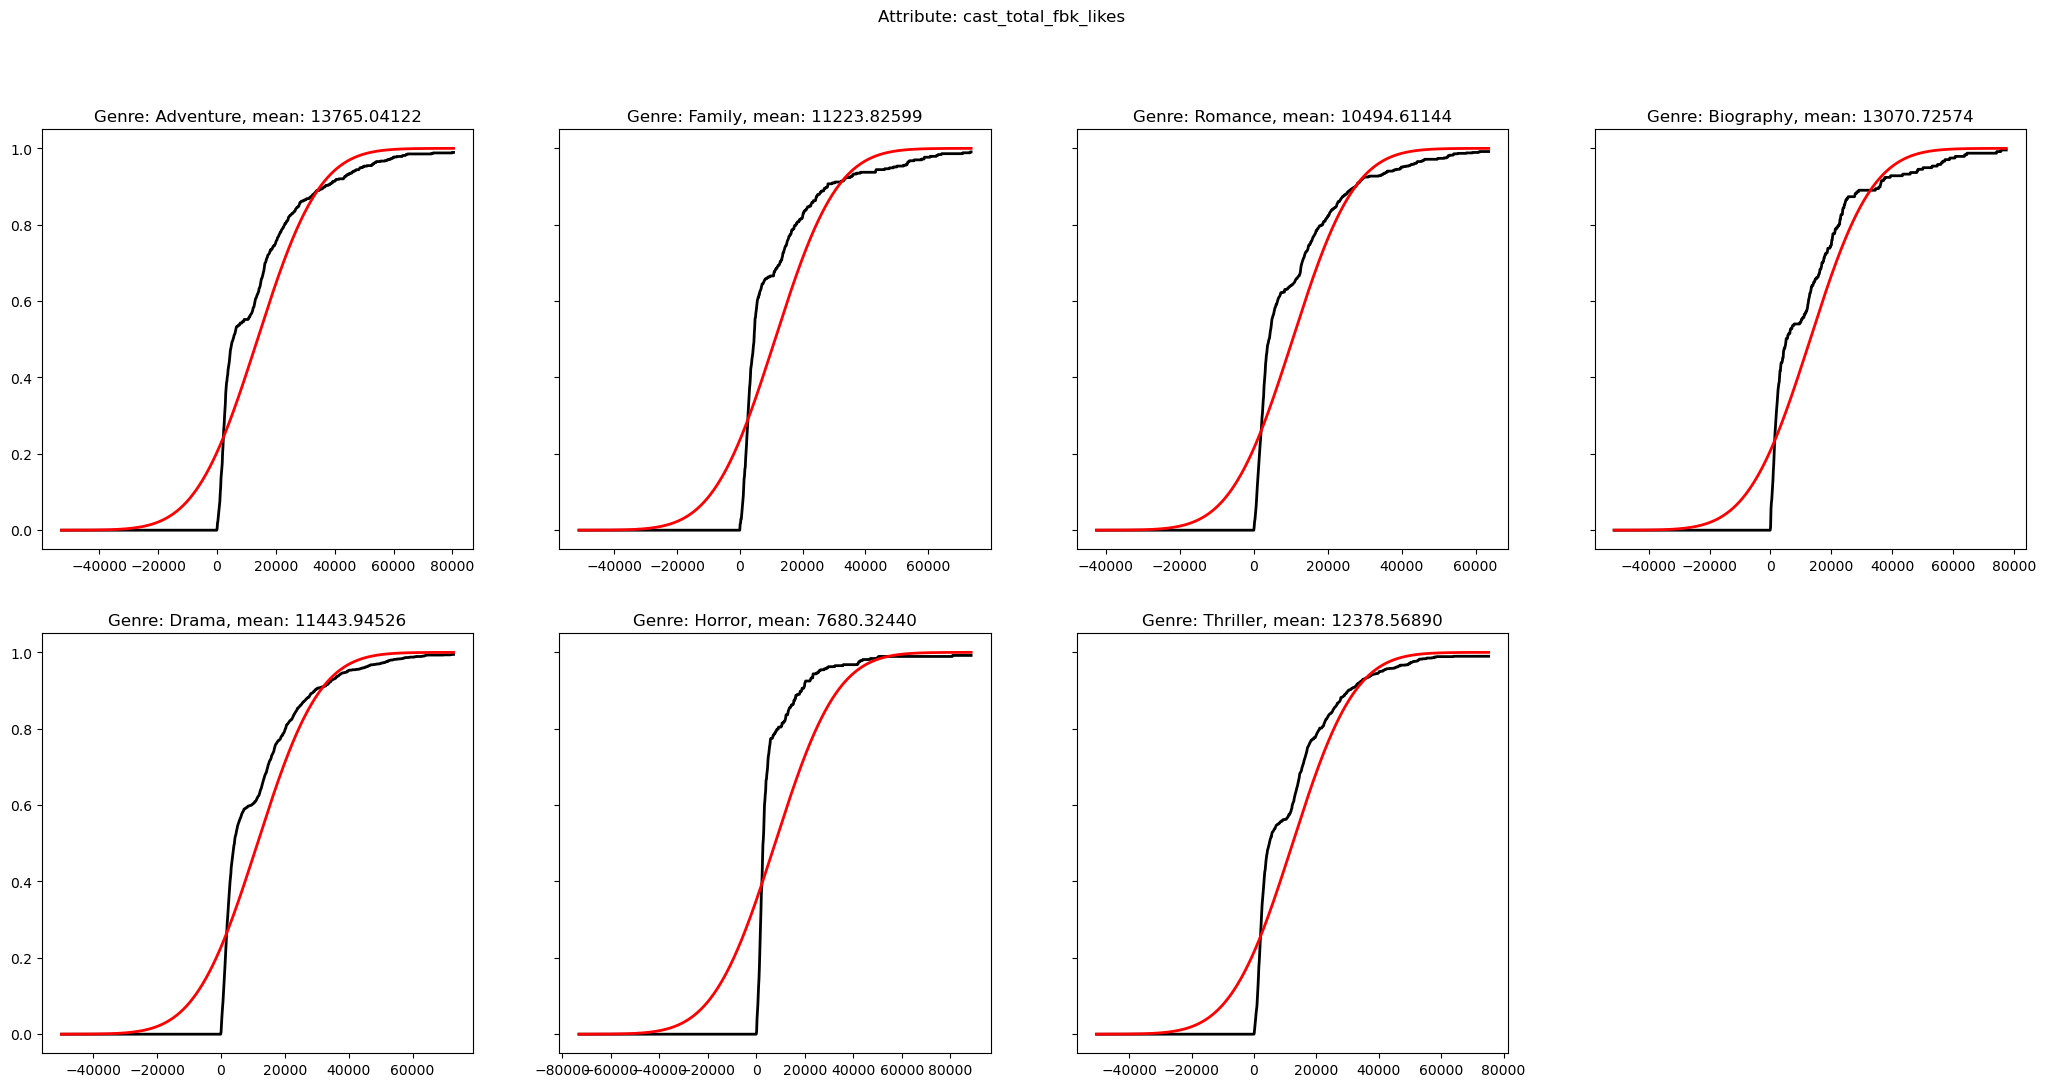

In [20]:

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    ecdf = ECDF(q_series)
    
    mean = q_series.mean()
    std = q_series.std(ddof=1)
    
    xax = np.linspace(mean - 4*std,mean + 4*std,1001)
    
    ax.plot(xax,ecdf(xax),c="k",lw=2)
    ax.plot(xax,norm(loc=mean,scale=std).cdf(xax),c="r",lw=2)
    
    ax.set_title(f"Genre: {q}, mean: {mean:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

In [21]:
for q1,q2 in zip(Top_genre[:-1],Top_genre[1:]):

    data_1 = col_series[col_series["genres"].str.contains(q1)][col].to_numpy()
    data_2 = col_series[col_series["genres"].str.contains(q2)][col].to_numpy()
    
    d0 = 0 
    dbar, _, p_value = bootstrap_diff_means(data_1,data_2)
    print(f"Comparing {col} for genre {q1} and {q2}")
    print(f"There is a probability of {p_value:.4f} that the observed difference of mean being different to {dbar:.4f} given the underlying difference of means is 0")
    print("\n")

Comparing cast_total_fbk_likes for genre Adventure and Family
There is a probability of 0.0084 that the observed difference of mean being different to 2541.2152 given the underlying difference of means is 0


Comparing cast_total_fbk_likes for genre Family and Romance
There is a probability of 0.4122 that the observed difference of mean being different to 729.2145 given the underlying difference of means is 0


Comparing cast_total_fbk_likes for genre Romance and Biography
There is a probability of 0.0260 that the observed difference of mean being different to -2576.1143 given the underlying difference of means is 0


Comparing cast_total_fbk_likes for genre Biography and Drama
There is a probability of 0.1419 that the observed difference of mean being different to 1626.7805 given the underlying difference of means is 0


Comparing cast_total_fbk_likes for genre Drama and Horror
There is a probability of 0.0136 that the observed difference of mean being different to 3763.6209 given the

So this implies that 'cast_total_fbk_likes' has not effect on the genre selection

## num_user_for_reviews

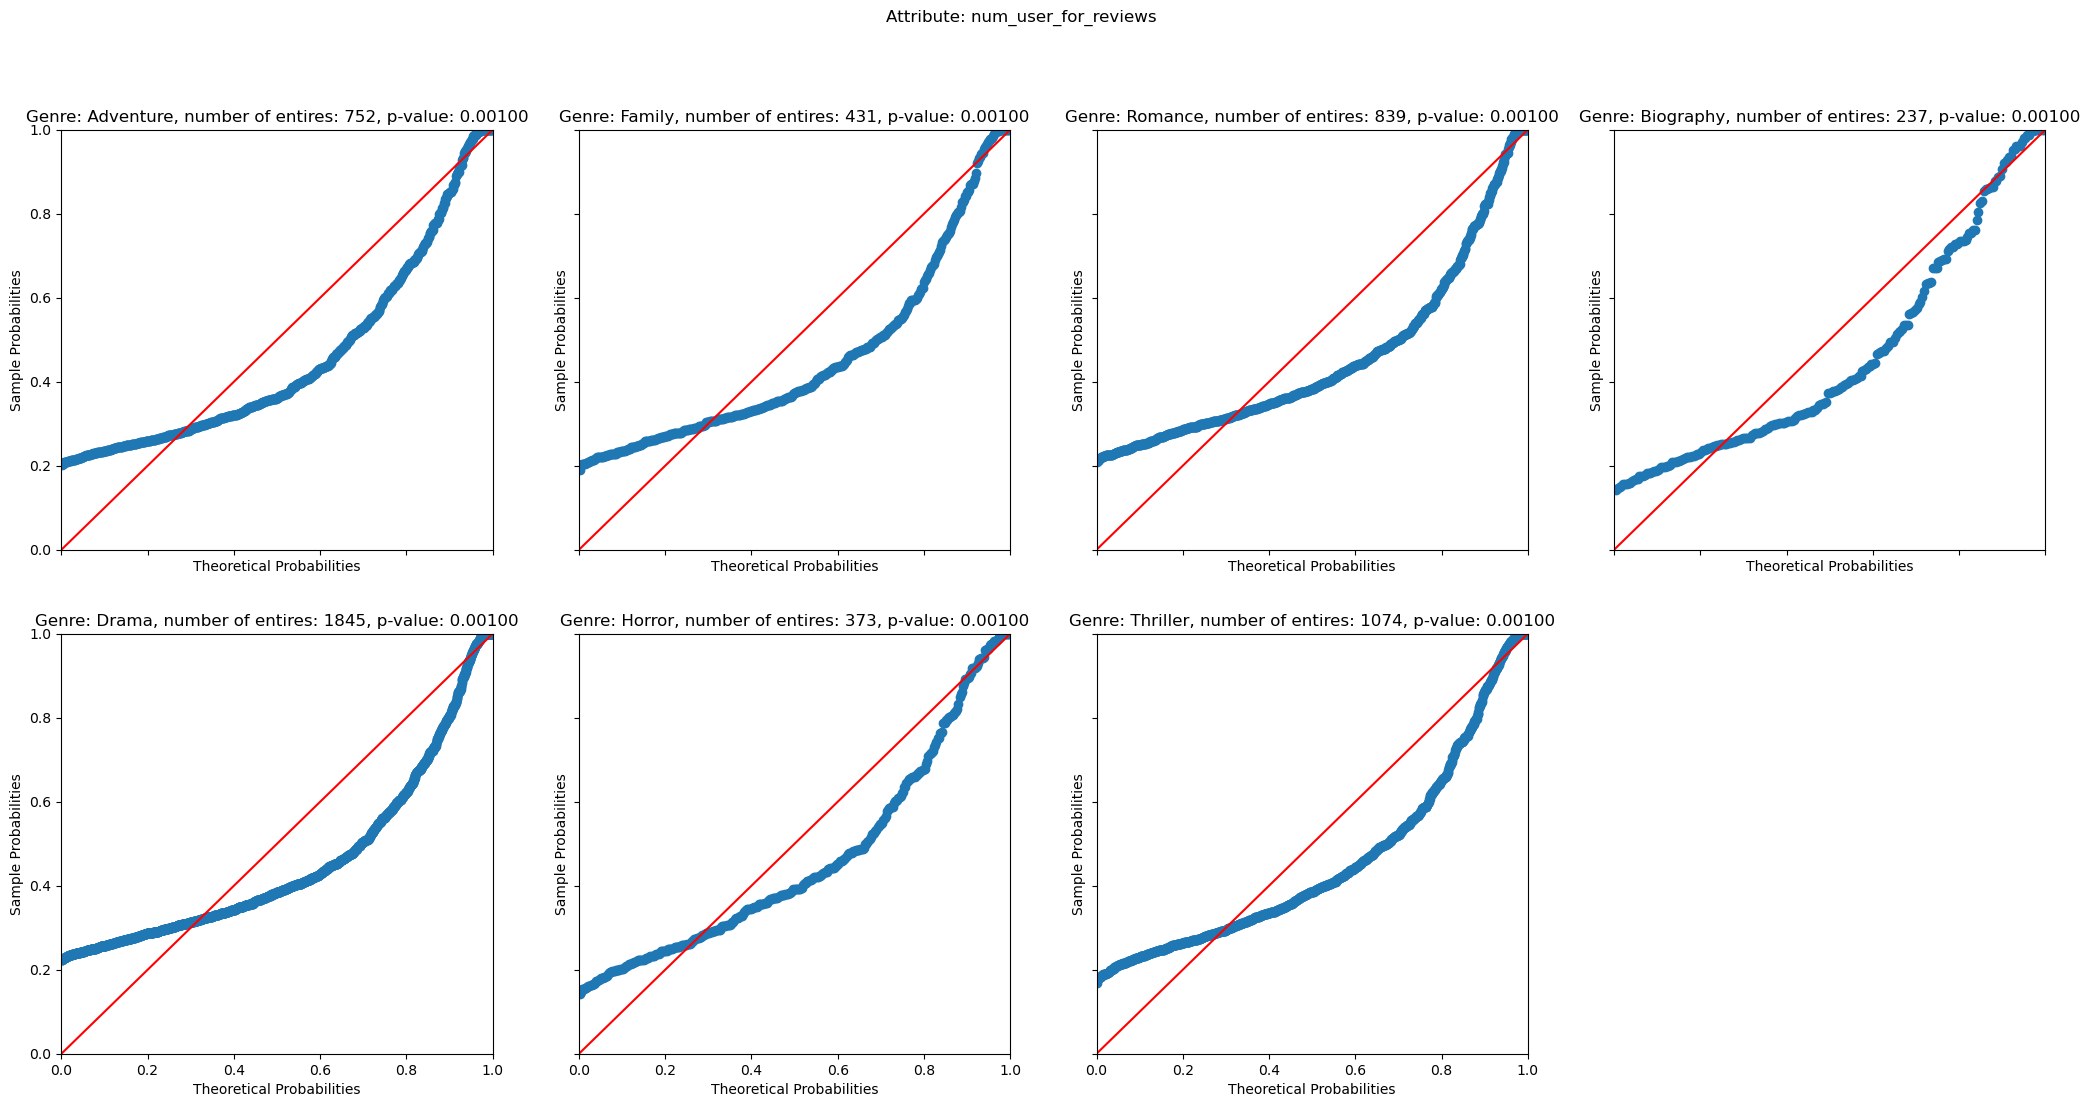

In [22]:
col = "num_user_for_reviews"
col_series = df[[col,"genres"]]

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    _, p_value = lilliefors(q_series,dist="norm")

    pp_x = sm.ProbPlot(q_series, dist=norm, fit=True)
    pp_x.ppplot(line="45",ax=ax)
    
    ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}, p-value: {p_value:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

None of the P-P plot looks gaussian, lets plot ecdf to check

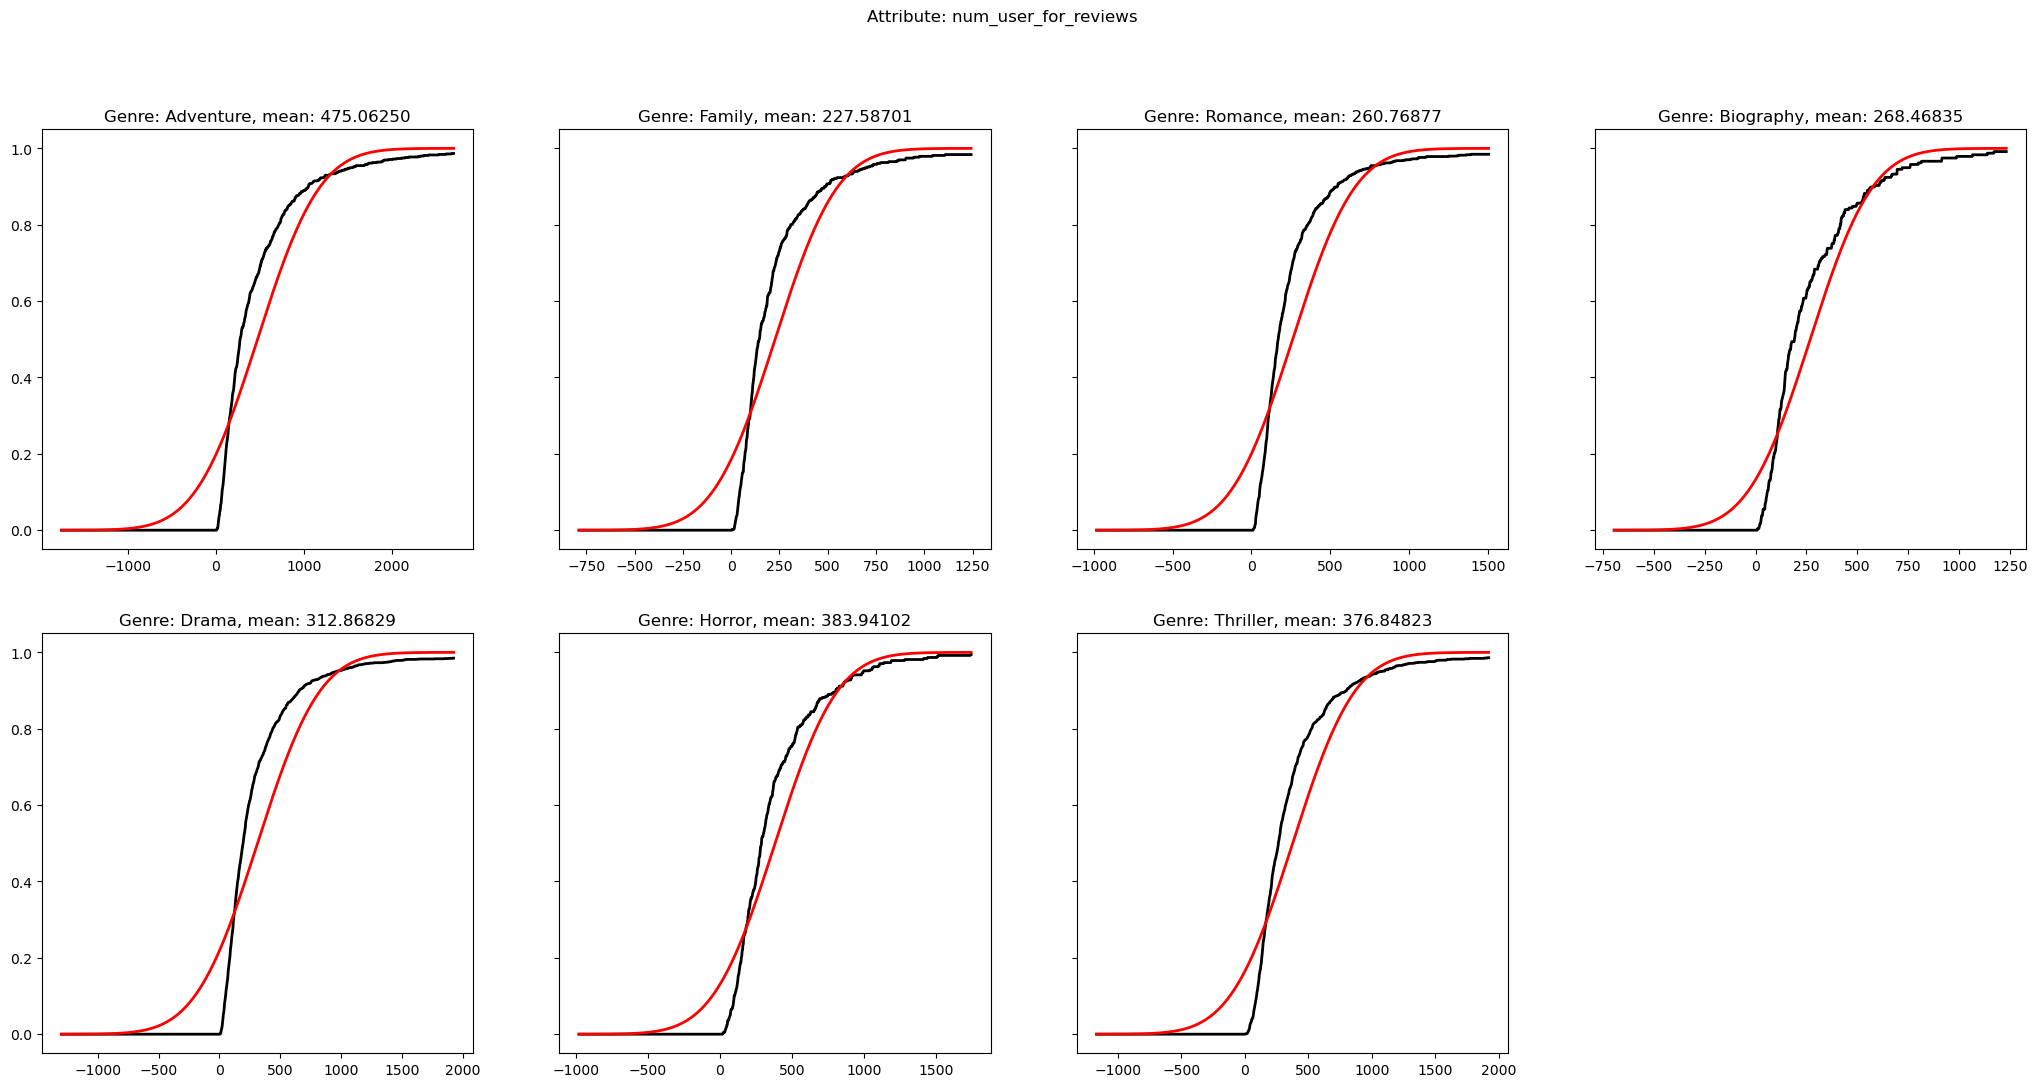

In [23]:

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    ecdf = ECDF(q_series)
    
    mean = q_series.mean()
    std = q_series.std(ddof=1)
    
    xax = np.linspace(mean - 4*std,mean + 4*std,1001)
    
    ax.plot(xax,ecdf(xax),c="k",lw=2)
    ax.plot(xax,norm(loc=mean,scale=std).cdf(xax),c="r",lw=2)
    
    ax.set_title(f"Genre: {q}, mean: {mean:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

In [24]:
for q1,q2 in zip(Top_genre[:-1],Top_genre[1:]):

    data_1 = col_series[col_series["genres"].str.contains(q1)][col].to_numpy()
    data_2 = col_series[col_series["genres"].str.contains(q2)][col].to_numpy()
    
    d0 = 0 
    dbar, _, p_value = bootstrap_diff_means(data_1,data_2)
    print(f"Comparing {col} for genre {q1} and {q2}")
    print(f"There is a probability of {p_value:.4f} that the observed difference of mean being different to {dbar:.4f} given the underlying difference of means is 0")
    print("\n")

Comparing num_user_for_reviews for genre Adventure and Family
There is a probability of 0.0001 that the observed difference of mean being different to 247.4755 given the underlying difference of means is 0


Comparing num_user_for_reviews for genre Family and Romance
There is a probability of 0.0392 that the observed difference of mean being different to -33.1818 given the underlying difference of means is 0


Comparing num_user_for_reviews for genre Romance and Biography
There is a probability of 0.6782 that the observed difference of mean being different to -7.6996 given the underlying difference of means is 0


Comparing num_user_for_reviews for genre Biography and Drama
There is a probability of 0.0151 that the observed difference of mean being different to -44.3999 given the underlying difference of means is 0


Comparing num_user_for_reviews for genre Drama and Horror
There is a probability of 0.0007 that the observed difference of mean being different to -71.0727 given the under

So this implies that there is statistically no significant difference between num_user_for_reviews for genres (Adventure, Family) and (Drama, Horror).

## budget

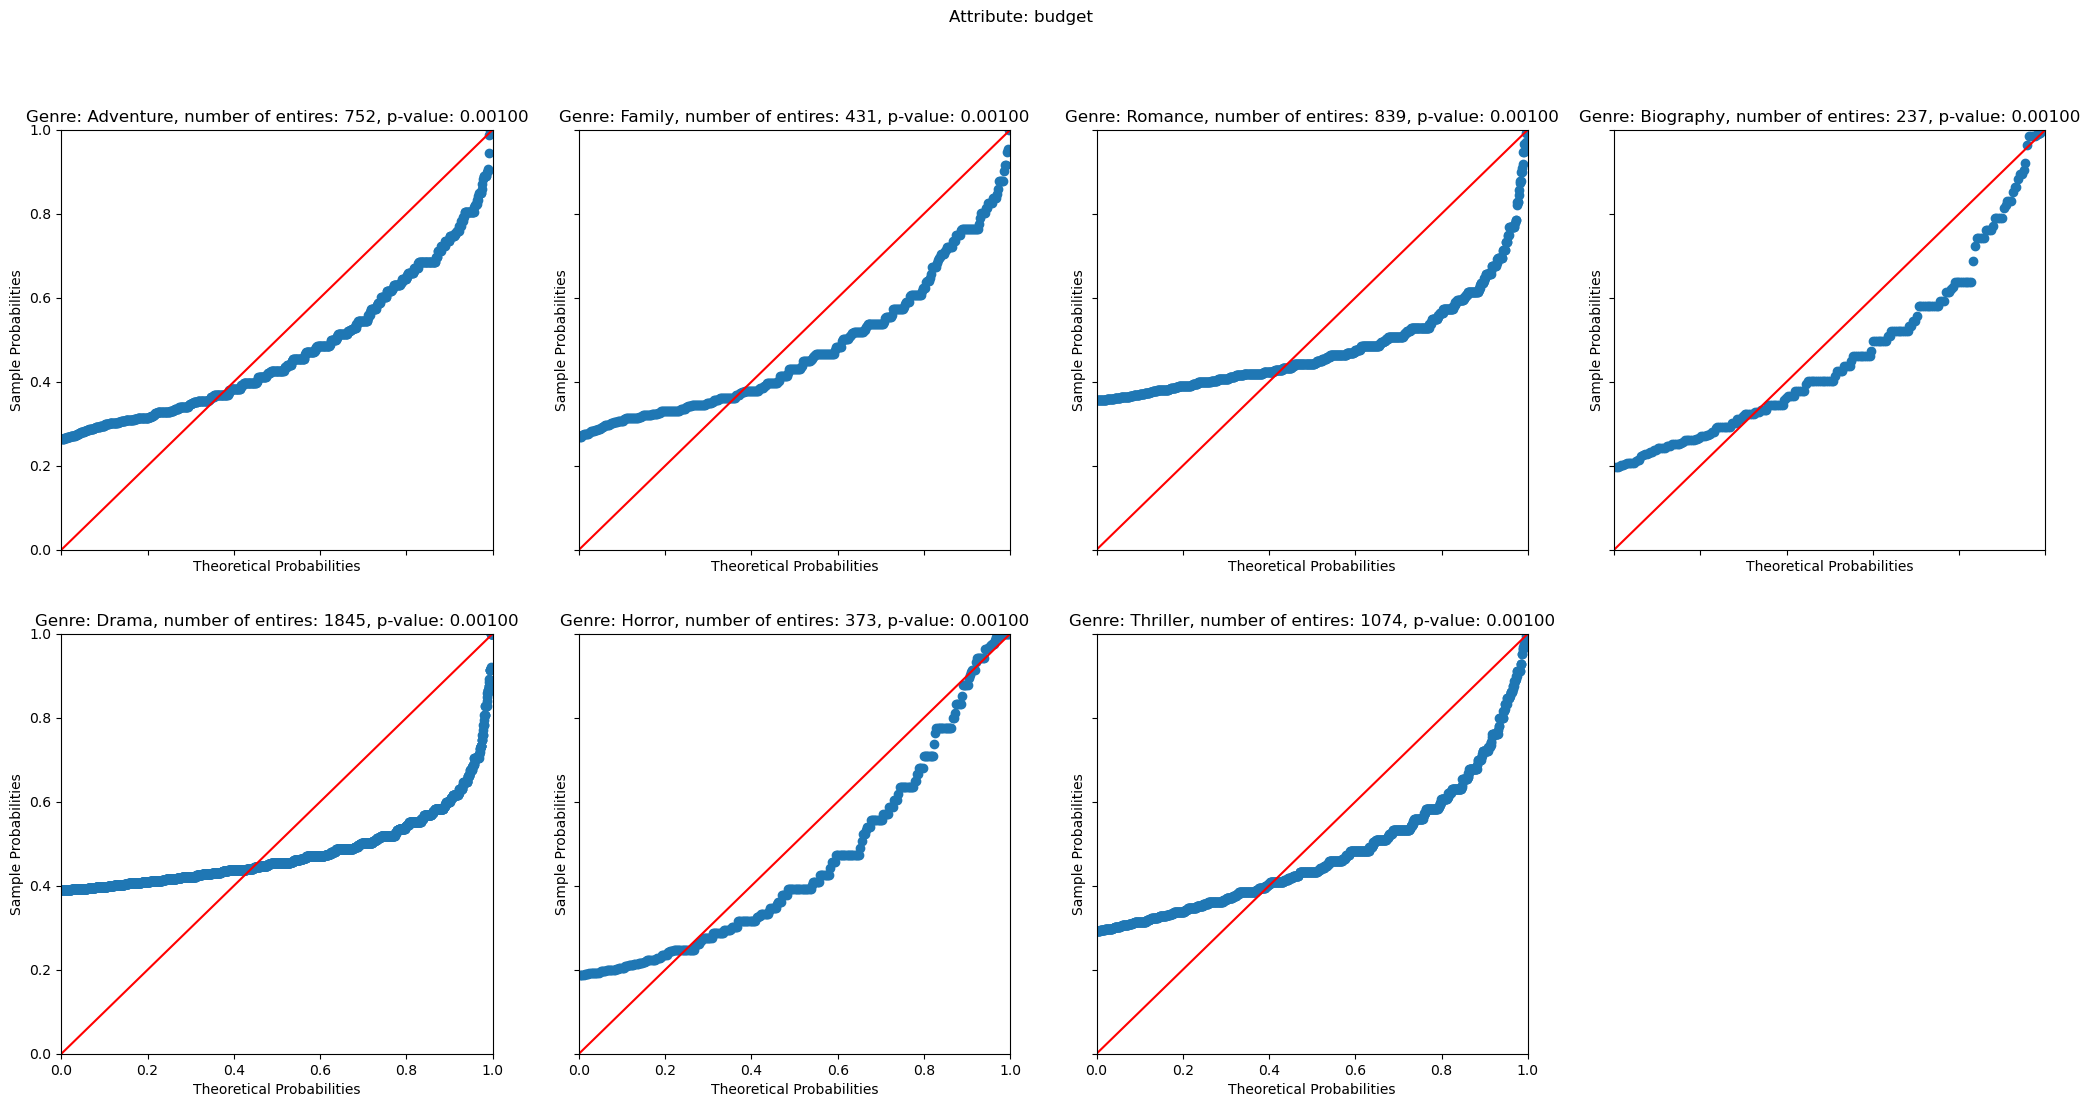

In [25]:
col = "budget"
col_series = df[[col,"genres"]]

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    _, p_value = lilliefors(q_series,dist="norm")

    pp_x = sm.ProbPlot(q_series, dist=norm, fit=True)
    pp_x.ppplot(line="45",ax=ax)
    
    ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}, p-value: {p_value:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

None of the P-P plot looks gaussian, lets plot ecdf to check

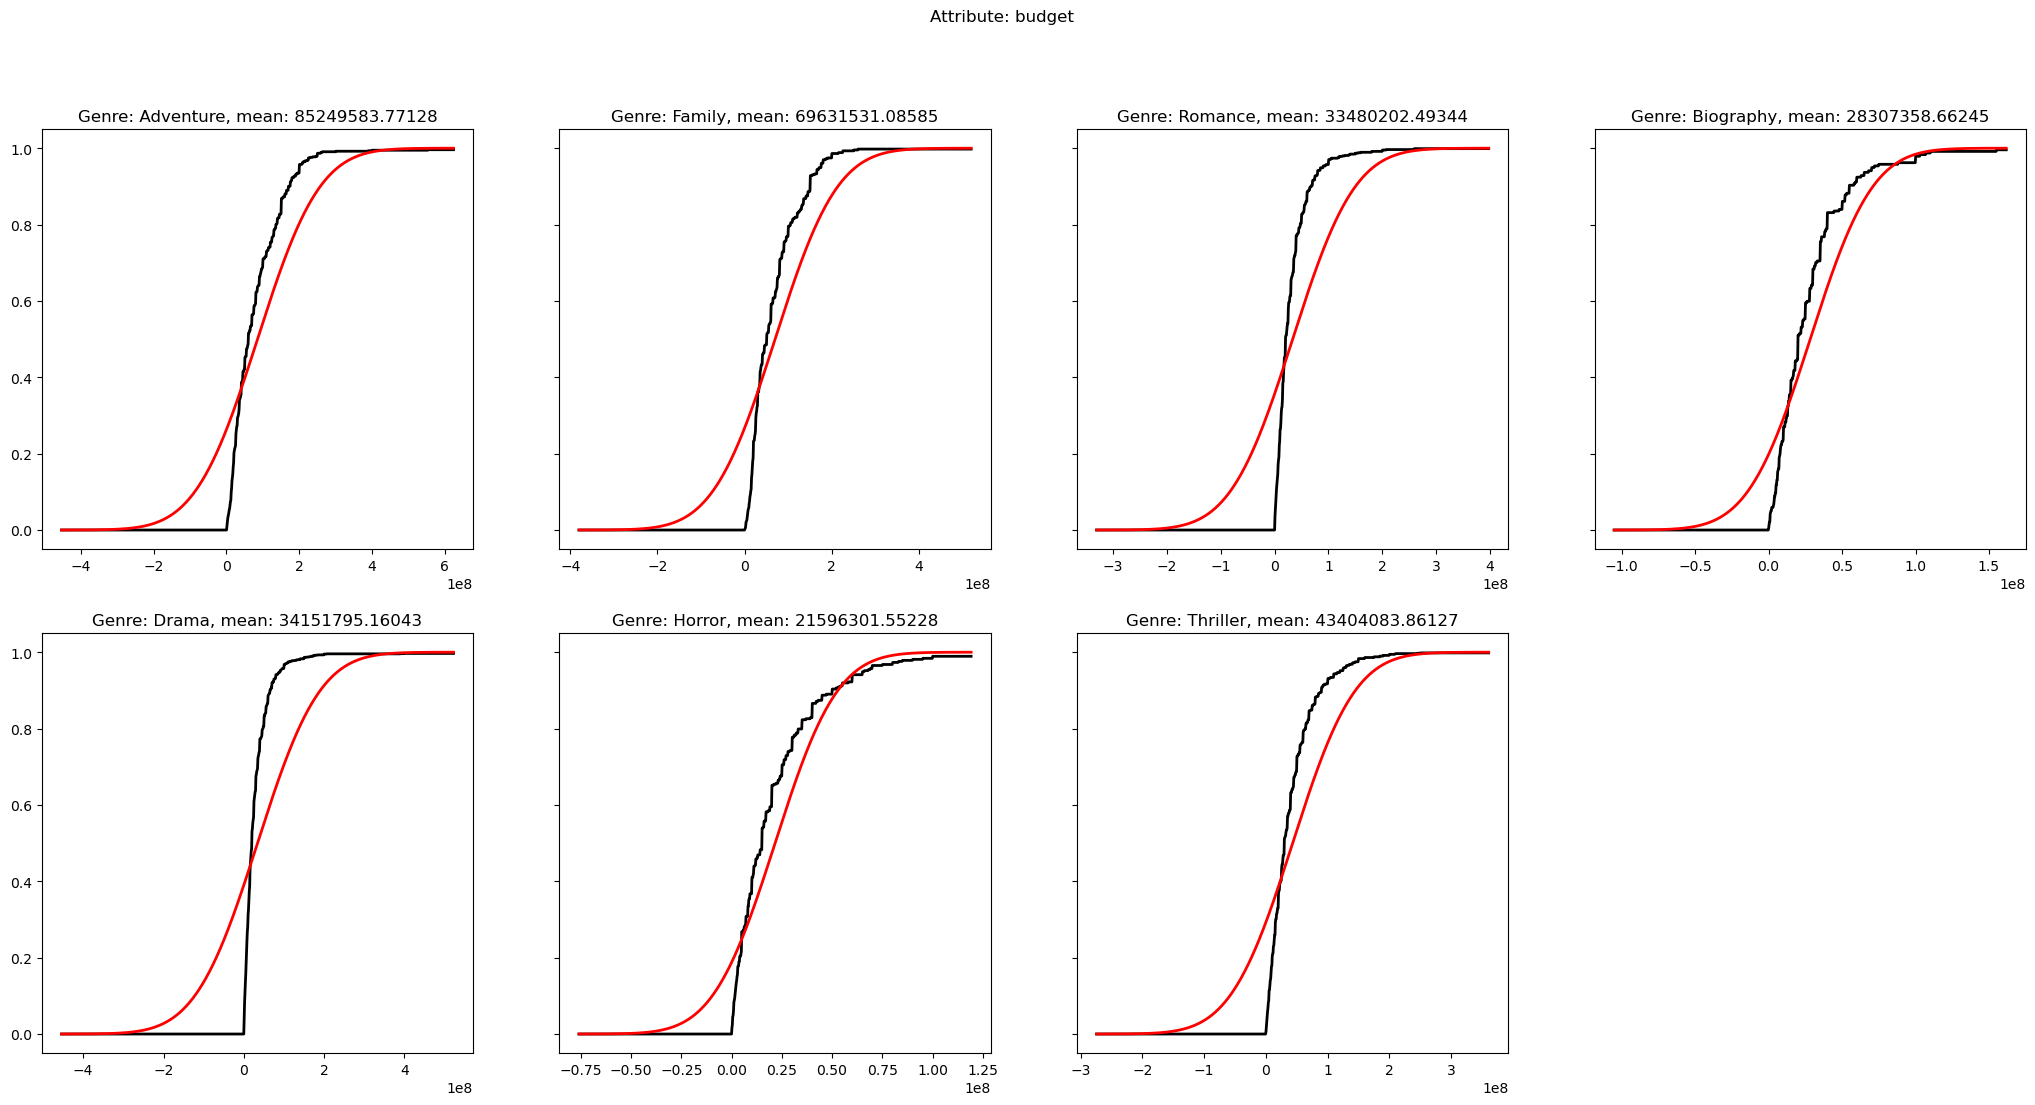

In [26]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    ecdf = ECDF(q_series)
    
    mean = q_series.mean()
    std = q_series.std(ddof=1)
    
    xax = np.linspace(mean - 4*std,mean + 4*std,1001)
    
    ax.plot(xax,ecdf(xax),c="k",lw=2)
    ax.plot(xax,norm(loc=mean,scale=std).cdf(xax),c="r",lw=2)
    
    ax.set_title(f"Genre: {q}, mean: {mean:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

In [27]:
for q1,q2 in zip(Top_genre[:-1],Top_genre[1:]):

    data_1 = col_series[col_series["genres"].str.contains(q1)][col].to_numpy()
    data_2 = col_series[col_series["genres"].str.contains(q2)][col].to_numpy()
    
    d0 = 0 
    dbar, _, p_value = bootstrap_diff_means(data_1,data_2)
    print(f"Comparing {col} for genre {q1} and {q2}")
    print(f"There is a probability of {p_value:.4f} that the observed difference of mean being different to {dbar:.4f} given the underlying difference of means is 0")
    print("\n")

Comparing budget for genre Adventure and Family
There is a probability of 0.0276 that the observed difference of mean being different to 15618052.6854 given the underlying difference of means is 0


Comparing budget for genre Family and Romance
There is a probability of 0.0001 that the observed difference of mean being different to 36151328.5924 given the underlying difference of means is 0


Comparing budget for genre Romance and Biography
There is a probability of 0.2159 that the observed difference of mean being different to 5172843.8310 given the underlying difference of means is 0


Comparing budget for genre Biography and Drama
There is a probability of 0.1135 that the observed difference of mean being different to -5844436.4980 given the underlying difference of means is 0


Comparing budget for genre Drama and Horror
There is a probability of 0.0060 that the observed difference of mean being different to 12555493.6082 given the underlying difference of means is 0


Comparing bu

## Profit

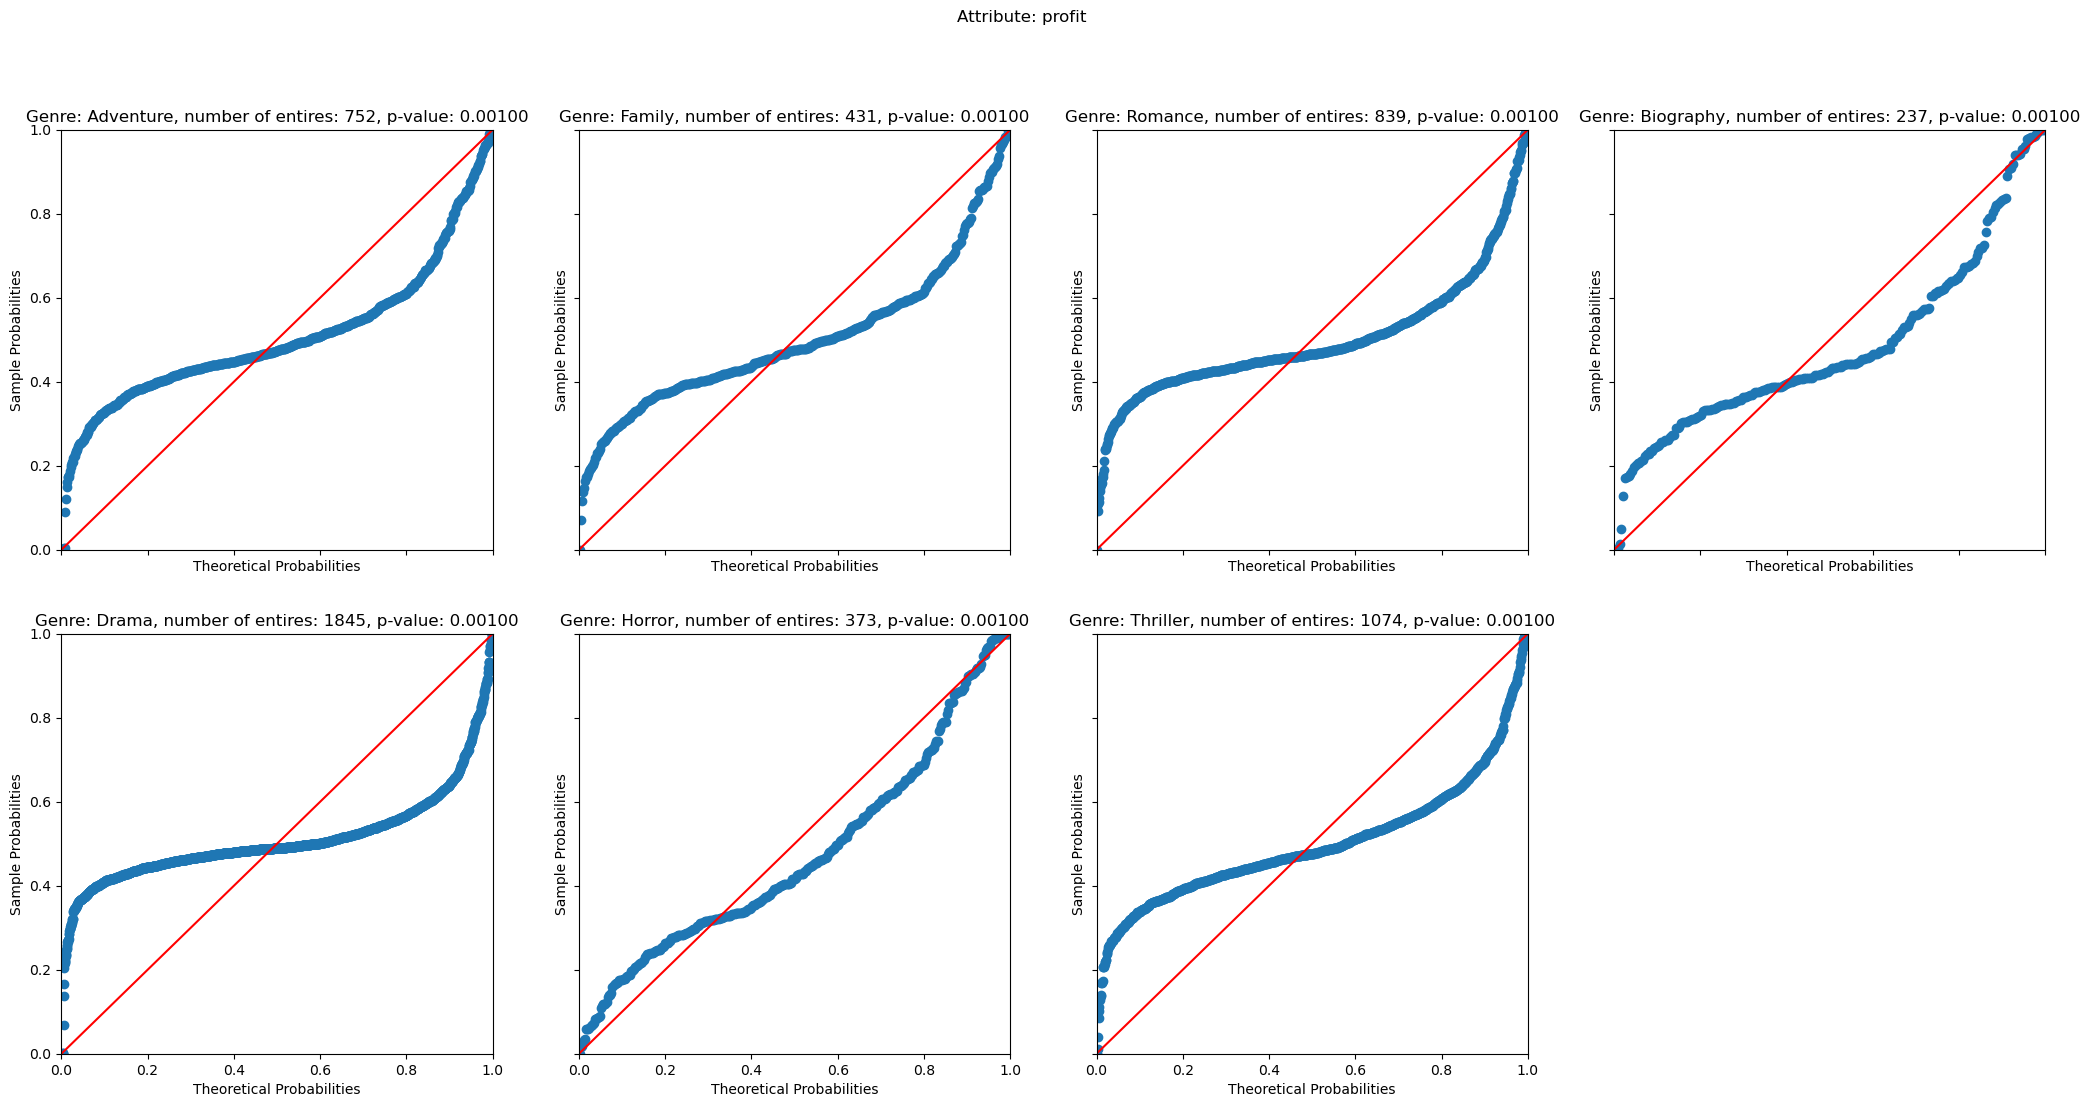

In [21]:
col = "profit"
col_series = df[[col,"genres"]]

fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    _, p_value = lilliefors(q_series,dist="norm")

    pp_x = sm.ProbPlot(q_series, dist=norm, fit=True)
    pp_x.ppplot(line="45",ax=ax)
    
    ax.set_title(f"Genre: {q}, number of entires: {len(q_series)}, p-value: {p_value:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

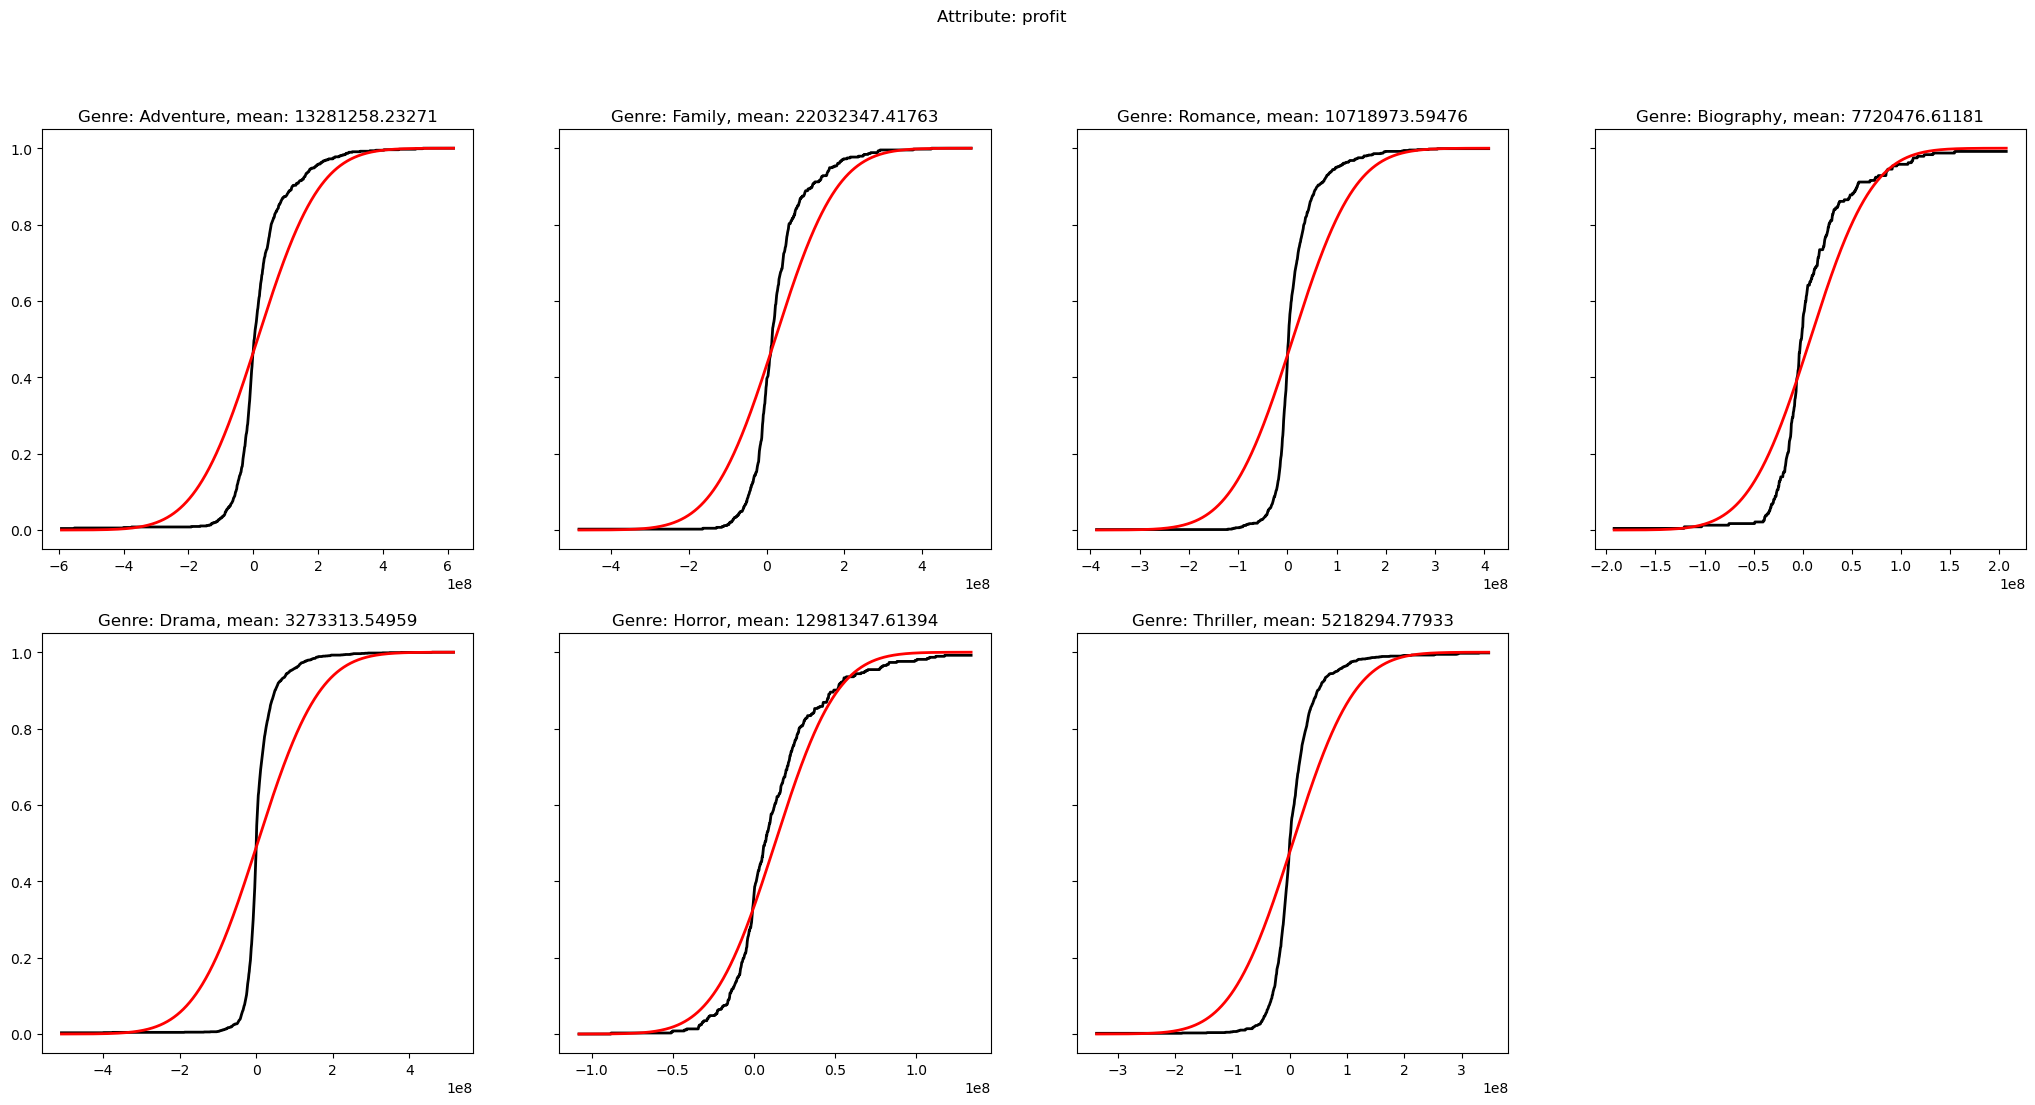

In [22]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, sharey=True)
for q,ax in zip(Top_genre,axes.flatten()):
    q_series = col_series[col_series["genres"].str.contains(q)][col]
    ecdf = ECDF(q_series)
    
    mean = q_series.mean()
    std = q_series.std(ddof=1)
    
    xax = np.linspace(mean - 4*std,mean + 4*std,1001)
    
    ax.plot(xax,ecdf(xax),c="k",lw=2)
    ax.plot(xax,norm(loc=mean,scale=std).cdf(xax),c="r",lw=2)
    
    ax.set_title(f"Genre: {q}, mean: {mean:.5f}")

fig.suptitle(f"Attribute: {col}")
fig.delaxes(axes[1][3])
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2.5)

In [23]:
for q1,q2 in zip(Top_genre[:-1],Top_genre[1:]):

    data_1 = col_series[col_series["genres"].str.contains(q1)][col].to_numpy()
    data_2 = col_series[col_series["genres"].str.contains(q2)][col].to_numpy()
    
    d0 = 0 
    dbar, _, p_value = bootstrap_diff_means(data_1,data_2)
    print(f"Comparing {col} for genre {q1} and {q2}")
    print(f"There is a probability of {p_value:.4f} that the observed difference of mean being different to {dbar:.4f} given the underlying difference of means is 0")
    print("\n")

Comparing profit for genre Adventure and Family
There is a probability of 0.2958 that the observed difference of mean being different to -8751089.1849 given the underlying difference of means is 0


Comparing profit for genre Family and Romance
There is a probability of 0.1128 that the observed difference of mean being different to 11313373.8229 given the underlying difference of means is 0


Comparing profit for genre Romance and Biography
There is a probability of 0.5442 that the observed difference of mean being different to 2998496.9829 given the underlying difference of means is 0


Comparing profit for genre Biography and Drama
There is a probability of 0.3252 that the observed difference of mean being different to 4447163.0622 given the underlying difference of means is 0


Comparing profit for genre Drama and Horror
There is a probability of 0.0224 that the observed difference of mean being different to -9708034.0643 given the underlying difference of means is 0


Comparing pro

So this implies that there is statistically significant difference between budget for genres (Family, Romance) and (Horror, Thriller).

The difference of means is suggesting the same thing across the different genres.

Making a movie in any of these genres ('Adventure','Family','Romance','Biography','Drama','Horror','Thriller') will get us good revenues but which genre to choose specifically?

As per the hypothesis tests, the genres `Drama` or `Horror|Thriller` will be the best bet.
